In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.stats import ttest_ind
import sys
#from scipy.stats import chi2_contingency
import numpy as np

In [2]:
dir_fig = 'notebook_trs/'

In [3]:
def xfeature(row, biotype):
	ret = 0
	for bio, con in zip(row['BIOTYPE'].split(','), row['Consequence'].split(',')):
		if bio == biotype and 'upstream_gene_variant' not in con and 'downstream_gene_variant' not in con:
			ret = 1
			break
	return ret

def xintergenic(row):
    ret = 0
    #cons_set_max = {'intergenic_variant', 'upstream_gene_variant', 'downstream_gene_variant'}
    cons_set_max = {'intergenic_variant'}
    cons_set = set(row['Consequence'].split(','))
    if (len(cons_set - cons_set_max) == 0) and (row['GENCODE'] == '.'):
        ret = 1
    return ret

def xgenic(row):
    ret = 0
    pli_all = []
    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
            continue
        pli_all.append(float(p))
    if len(pli_all) > 0:
        ret = 1
    return ret

def xpli(row, pli_thr, gen_list=[]):
	ret = 0
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

#def xlowpli(row, pli_thr, gen_list=[]):
#    ret = 1
#    if (row['Consequence'] == 'intergenic_variant'):
#        return 0
#    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
#        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
#            continue
#        if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
#            ret = 0
#            break
#    return ret

def xlowpli(row, pli_thr, gen_list=[]):
    ret = 0
    pli_all = []
    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
            continue
        pli_all.append(float(p))
    if len(pli_all) > 0 and max(pli_all) < pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
        ret = 1
    return ret

def xloeuf(row, l_thr, gen_list=[]):
	ret = 0
	for l, con in zip(row['GENES_LOEUF'].split(','), row['Consequence'].split(',')):
		if (l == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(l) <= l_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfdr(row, f_type, f_thr, gen_list=[]):
	ret = 0
	for f, con in zip(row['GENES_FDR_'+f_type].split(','), row['Consequence'].split(',')):
		if (f == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(f) <= f_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfb_pr_enh(row, fb_set):
    ret = 0
    if row['FB_PR_ENH_M'] != '.' and len( set(row['FB_PR_ENH_M'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    if row['FB_PR_ENH_F'] != '.' and len( set(row['FB_PR_ENH_F'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    return ret

def xgnocchi(row, col, gn_thr):
    ret = 0
    #if (row['GNOCCHI'] != '.') and (float(row['GNOCCHI']) > gn_thr):
    if (row[col] != '.') and (float(row[col]) > gn_thr):
        ret = 1
    return ret

def xfantom(row):
    ret = 0
    if row['FANTOM_ENH'] == 'FanEnh':
        ret = 1
    return ret

def status_num(row, cols):
    col_case_nums = []
    col_control_nums = []
    for c in cols:
        col = f'case_{c}'
        if row[col] == '.' or row[col] == '':
            col_case_nums.append(0)
            col_control_nums.append(0)
            continue
        n_case = len([x for x in row[col].split(',') if x == 'Yes'])
        n_control = len([x for x in row[col].split(',') if x == 'No'])
        col_case_nums.append(n_case)
        col_control_nums.append(n_control)
    return *col_case_nums, *col_control_nums

def large_zs(row, zs_col, zs_thr, q_thr=None, hc_samples=None, quality_samples=False, len_thr=0, supp_thr=0, famid_samples_dict=None, sample_famid_dict=None):
    lzs_samples = ''
    lzs_samples_case = ''
    sep = ''
    if row[zs_col] == '.':
        return lzs_samples, lzs_samples_case
    if quality_samples:
        q_samples = [x.split(':')[0] for x in row[f'Q{q_thr}_SAMPLES_GB'].split(',') if x != '.']
    ngt_samples = row['NGT_SAMPLES'].split(',')
    hp1_samples = [x.split(':')[0] for x in row['HP1_SAMPLES_PDP'].split(',') if x != '.']
    hp2_samples = [x.split(':')[0] for x in row['HP2_SAMPLES_PDP'].split(',') if x != '.']
    for x, aff in zip(row[zs_col].split(','), row[f'case_{zs_col}'].split(',')):
        #REACH000001:-3.49|0.30:-40|0:-40|1x0|8
        sample = x.split(':')[0]
        zss = x.split(':')[1].split('|')
        gbs = x.split(':')[2].split('|')
        supp_dict = {xx.split('|')[0]: xx.split('|')[1] for xx in x.split(':')[-1].split('x')}

        #all_family_present = True
        #famid = sample_famid_dict[sample]
        #samples_fam = famid_samples_dict[famid]
        #for sam in samples_fam:
        #    if (sam in ngt_samples):
        #        all_family_present = False
        #        break
                
        all_family_hp12 = True
        famid = sample_famid_dict[sample]
        samples_fam = famid_samples_dict[famid]
        for sam in samples_fam:
            if (sam not in hp1_samples) or (sam not in hp2_samples):
                all_family_hp12 = False
                break
        

        is_sig = False
        for zs, gb in zip(zss, gbs):
            if (abs(float(zs)) >= zs_thr) and (abs(int(gb)) >= len_thr) and (int(supp_dict[gb]) >= supp_thr):
                is_sig = True
        #if is_sig and all_family_present:
        if is_sig and all_family_hp12:
            if quality_samples:
                if (sample in q_samples) and ((hc_samples == None) or (sample in hc_samples)):
                    lzs_samples = lzs_samples + sep + x
                    lzs_samples_case = lzs_samples_case + sep + aff
                    sep = ','
            else:
                if ((hc_samples == None) or (sample in hc_samples)):
                    lzs_samples = lzs_samples + sep + x
                    lzs_samples_case = lzs_samples_case + sep + aff
                    sep = ','
    return lzs_samples, lzs_samples_case

def xgencode(row, gen_list, feature):	
	ret = 0
	if row[feature] == 1 and row['GENCODE'] in (gen_list):
		ret = 1
	return ret

def x2features(row, feature1, feature2):
    ret = 0
    if row[feature1] == 1 and row[feature2] == 1:
        ret = 1
    return ret

def count_num(row, col):
    ret = 0
    if row[col] == '.' or row[col] == '':
        return ret
    ret = len(row[col].split(','))
    return ret

def xdev_br(row, dev_br_list):
	ret = 0
	for sym, con in zip(row['SYMBOL'].split(','), row['Consequence'].split(',')):
		if (sym == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if sym in dev_br_list:
			ret = 1
			break
	return ret

def get_freq(row, col_lr, parents_set):
    parents = [x for x in row[col_lr].split(',') if x.split(':')[0] in parents_set]
    freq = float(f'{len(parents) / len(parents_set):.4f}')
    return freq

def xconserv(row, col, cons_thr):
    ret = 0
    if (row[col] != '.') and (float(row[col]) >= cons_thr):
        ret = 1
    return ret

def xsHet(row, s_thr):
	ret = 0
	for s, con in zip(row['GENES_S_HET'].split(','), row['Consequence'].split(',')):
		if (s == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(s) >= s_thr:
			ret = 1
			break
	return ret

In [4]:
def is_close(kid_gt, par_gts, err_thr=0.2):
    err_min = np.min([abs((kid_gt-par_gt) / (par_gt+.001)) for par_gt in par_gts])
    if err_min <= err_thr:
        return True
    return False

def get_trans(row, col, mom_kids_dict, dad_kids_dict, parent_kids_dict, mate_dict ,aff_dict, gt_thr=0, add_len_thr=False, 
              len_thr=0, plat=None, supp_thr=2):
    num_tran_case = 0
    num_tran_control = 0
    num_nontran_case = 0
    num_nontran_control = 0
    tran_list = []
    nontran_list = []
    #if row['CHROM'] == 'chrX' or row['CHROM'] == 'chrY':
    #    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control, '', ''
    q_samples = [x.split(':')[0] for x in row['Q90_SAMPLES_GB'].split(',') if x != '.']
    hp1_samples = [x.split(':')[0] for x in row['HP1_SAMPLES_PDP'].split(',') if x != '.']
    hp2_samples = [x.split(':')[0] for x in row['HP2_SAMPLES_PDP'].split(',') if x != '.']
    hem_samples = [x.split(':')[0] for x in row['HEM_SAMPLES_DP'].split(',') if x != '.']
    
    moms = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in mom_kids_dict]
    dads = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in dad_kids_dict]
    mom_mates = [mate_dict[x] for x in moms]
    dad_mates = [mate_dict[x] for x in dads]
    mom_kids = [mom_kids_dict[x] for x in moms]
    dad_kids = [dad_kids_dict[x] for x in dads]
    
    if 'LARGE' in col:
        #sample_gt_dict = {x.split(':')[0]:(int(x.split(':')[1].split('|')[0]), int(x.split(':')[1].split('|')[1])) 
        #                  for x in row[col].split(',') if x != '.'}
        sample_gt_dict = {x.split(':')[0]: (int(x.split(':')[1].split('|')[0]), int(x.split(':')[1].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[1].split('|'))==2)) 
                          else ((int(x.split(':')[1].split('|')[0]),) if ((x != '.') and (len(x.split(':')[1].split('|'))==1)) else '.')
                          for x in row[col].split(',')}
        sample_len_dict = sample_gt_dict
    elif 'ZS_' in col:
        #sample_gt_dict = {x.split(':')[0]:(float(x.split(':')[1].split('|')[0]), float(x.split(':')[1].split('|')[1])) 
        #                  for x in row[col].split(',') if x != '.'}
        #sample_len_dict = {x.split(':')[0]:(int(x.split(':')[2].split('|')[0]), int(x.split(':')[2].split('|')[1])) 
        #                   for x in row[col].split(',') if x != '.'}
        sample_gt_dict = {x.split(':')[0]: (float(x.split(':')[1].split('|')[0]), float(x.split(':')[1].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[1].split('|'))==2)) 
                          else ((float(x.split(':')[1].split('|')[0]),) if ((x != '.') and (len(x.split(':')[1].split('|'))==1)) else '.')
                          for x in row[col].split(',')}
        sample_len_dict = {x.split(':')[0]: (int(x.split(':')[2].split('|')[0]), int(x.split(':')[2].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[2].split('|'))==2)) 
                          else ((int(x.split(':')[2].split('|')[0]),) if ((x != '.') and (len(x.split(':')[2].split('|'))==1)) else '.')
                          for x in row[col].split(',')}

    sample_supp_dict = {x.split(':')[0]: {int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1]), 
                                           int(x.split(':')[-1].split('x')[1].split('|')[0]): int(x.split(':')[-1].split('x')[1].split('|')[1])} 
                        if ((x != '.') and (len(x.split(':')[-1].split('x'))==2)) 
                        else ({int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1])} 
                              if ((x != '.') and (len(x.split(':')[-1].split('x'))==1)) else '.') for x in row[col].split(',')}

    #print(f'moms:{moms}')
    #print(f'dads:{dads}')
    #print(f'mom_mates: {mom_mates}')
    #print(f'dad_mates: {dad_mates}')
    #print(f'mom_kids: {mom_kids}')
    #print(f'dad_kids: {dad_kids}')
    #print(f'sample_gt_dict: {sample_gt_dict}')
    #print(f'sample_len_dict: {sample_len_dict}')
    #print(f'sample_supp_dict: {sample_supp_dict}')

    parss = [moms, dads]
    par_matess = [mom_mates, dad_mates]
    par_kidss = [mom_kids, dad_kids]
    par_hp_idxs = [1, 0]
    other_par_hp_idxs = [0, 1]

    for pars, par_mates, par_kids, par_hp_idx, other_par_hp_idx in zip(parss, par_matess, par_kidss, par_hp_idxs, other_par_hp_idxs):
        for par1, par2, kids in zip(pars, par_mates, par_kids):
            par1_gts = sample_gt_dict[par1]
            par1_lens = sample_len_dict[par1]
            par1_supp = sample_supp_dict[par1]
            gt_good = False
            for gt, l in zip(par1_gts, par1_lens):
                supp = par1_supp[l]
                #if (abs(gt) >= gt_thr) and (supp>=supp_thr) and (par1 in q_samples):
                if (abs(gt) >= gt_thr) and (supp>=supp_thr):
                    gt_good = True
                    #print('THIS IS GOOD GT...')
            if (not gt_good):
                continue
            #if np.max(np.abs(par1_gts)) < gt_thr:
            #    continue
            if add_len_thr and (np.max(np.abs(sample_len_dict[par1])) < len_thr):
                continue
            if (plat!=None) and (plat_dict[par1]!=plat):
                continue
            for k in kids:
                if k in sample_gt_dict:
                    kid_gts = sample_gt_dict[k]
                    # if variant is on chrX or chrY and kid is male we have one genotype
                    if len(kid_gts) == 1:
                        if (abs(kid_gts[0]) >= gt_thr*.8) and is_close(kid_gts[0], par1_gts):
                            if aff_dict[k] == 'Yes':
                                num_tran_case += 1
                            elif aff_dict[k] == 'No':
                                num_tran_control += 1
                            tran_list.append(k)
                        elif k in hem_samples:
                            if aff_dict[k] == 'Yes':
                                num_nontran_case += 1
                            elif aff_dict[k] == 'No':
                                num_nontran_control += 1
                            nontran_list.append(k)
                        continue
                    if (abs(kid_gts[par_hp_idx]) >= gt_thr*.8) and is_close(kid_gts[par_hp_idx], par1_gts):
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                        tran_list.append(k)
                    elif (abs(kid_gts[other_par_hp_idx]) >= gt_thr*.8) and is_close(kid_gts[other_par_hp_idx], par1_gts):
                        if (par2 not in sample_gt_dict):
                            if aff_dict[k] == 'Yes':
                                num_tran_case += 1
                            elif aff_dict[k] == 'No':
                                num_tran_control += 1
                            tran_list.append(k)
                        else:
                            par2_gts = sample_gt_dict[par2]
                            if (not is_close(kid_gts[other_par_hp_idx], par2_gts)):
                                if aff_dict[k] == 'Yes':
                                    num_tran_case += 1
                                elif aff_dict[k] == 'No':
                                    num_tran_control += 1
                                tran_list.append(k)
                    elif ((k in hp1_samples) and (k in hp2_samples)) or (k in hem_samples):
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 1
                        nontran_list.append(k)
                elif ((k in hp1_samples) and (k in hp2_samples)) or (k in hem_samples):
                    if aff_dict[k] == 'Yes':
                        num_nontran_case += 1
                    elif aff_dict[k] == 'No':
                        num_nontran_control += 1
                    nontran_list.append(k)

    tran_str = ','.join(tran_list)
    nontran_str = ','.join(nontran_list)

    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control, tran_str, nontran_str

In [5]:
#lzs_thrs = [10]
#lzs_thrs = [7, 8, 9, 10, 11, 12, 13, 14]
lzs_thrs = [3, 5, 7, 9]
lzs_tran_thrs = [3, 5, 7, 9]
#supp_thr = 2
supp_thrs = [1, 2, 3]
len_thr_gl = 50
q_thr = 90

In [6]:
def get_big_table(file_name):
    df = pd.read_table(file_name, sep='\t', header=0)
    #, nrows=20000)

    ############ testing ##############
    #print('extract large ZS samples...')
    #for zs_thr in lzs_thrs[:1]:
    #    zs_col = 'ZS_SAMPLES'
    #    print(f'   zs_thr: {zs_thr}, {zs_col}')
    #    for supp_thr in supp_thrs[:1]:
    #        df[[f'LZS{zs_thr}_SAMPLES_SUPP{supp_thr}_Q', 
    #            f'case_LZS{zs_thr}_SAMPLES_SUPP{supp_thr}_Q']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, q_thr, 
    #                                                                                           quality_samples=True, len_thr=len_thr_gl, 
    #                                                                                           supp_thr=supp_thr, famid_samples_dict=famid_samples_dict, 
    #                                                                                           sample_famid_dict=sample_famid_dict), 
    #                                                                      axis=1, result_type='expand')
    #return df
    #df = df.loc[df.CHROM=='chrX'].copy()
    #df = df.reset_index()
    ##reindex(index=(range(df.shape[0])))
    #print('raw data:')
    #display(df)

    #col = 'ZS_SAMPLES'
    ##col = 'LARGE25_DEV_GB'
    #gt_thr = 3
    ##gt_thr = 100
    #add_len_thr = True
    #len_thr = 0
    #this_df = df.loc[:10,:].apply(lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
    #                                parent_kids_dict, mate_dict, aff_dict, 
    #                             gt_thr=gt_thr, add_len_thr=add_len_thr, len_thr=len_thr, supp_thr=supp_thr), axis=1, result_type='expand')

    #print('this_df:')
    #print(this_df)
    #return df
    ######################################

    #**s_thr = .1
    #**print(f's_het {s_thr}...')
    #**flag = f'{int(s_thr*1000)}'
    #**df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    #**feature = f'X_S_HET_{flag}'
    #**print(f's_het subsets {flag}...')
    #**gen_list = ['CDS', 'start_codon', 'stop_codon']
    #**df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    #**df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #**df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################

    #**s_thr = .01
    #**print(f's_het {s_thr}...')
    #**flag = f'{int(s_thr*1000)}'
    #**df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    #**feature = f'X_S_HET_{flag}'
    #**print(f's_het subsets {flag}...')
    #**gen_list = ['CDS', 'start_codon', 'stop_codon']
    #**df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    #**df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #**df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################

    #**s_thr = .001
    #**print(f's_het {s_thr}...')
    #**flag = f'{int(s_thr*1000)}'
    #**df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    #**feature = f'X_S_HET_{flag}'
    #**print(f's_het subsets {flag}...')
    #**gen_list = ['CDS', 'start_codon', 'stop_codon']
    #**df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    #**df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #**gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #**df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################

    print('extract large ZS samples...')
    for zs_thr in lzs_thrs:
        zs_col = 'ZS_SAMPLES'
        print(f'   zs_thr: {zs_thr}, {zs_col}')
        df[[f'LZS{zs_thr}_SAMPLES', 
            f'case_LZS{zs_thr}_SAMPLES']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, len_thr=len_thr_gl, famid_samples_dict=famid_samples_dict, 
                                                                          sample_famid_dict=sample_famid_dict), 
                                                     axis=1, result_type='expand')
        df[[f'LZS{zs_thr}_SAMPLES_Q', 
            f'case_LZS{zs_thr}_SAMPLES_Q']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, q_thr, 
                                                                            quality_samples=True, len_thr=len_thr_gl, famid_samples_dict=famid_samples_dict, 
                                                                            sample_famid_dict=sample_famid_dict), 
                                                       axis=1, result_type='expand')

        for supp_thr in supp_thrs:
            df[[f'LZS{zs_thr}_SAMPLES_SUPP{supp_thr}', 
                f'case_LZS{zs_thr}_SAMPLES_SUPP{supp_thr}']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, len_thr=len_thr_gl, 
                                                                                             supp_thr=supp_thr, famid_samples_dict=famid_samples_dict, 
                                                                                             sample_famid_dict=sample_famid_dict), 
                                                                        axis=1, result_type='expand')
            df[[f'LZS{zs_thr}_SAMPLES_SUPP{supp_thr}_Q', 
                f'case_LZS{zs_thr}_SAMPLES_SUPP{supp_thr}_Q']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, q_thr, 
                                                                                               quality_samples=True, len_thr=len_thr_gl, 
                                                                                               supp_thr=supp_thr, famid_samples_dict=famid_samples_dict, 
                                                                                               sample_famid_dict=sample_famid_dict), 
                                                                          axis=1, result_type='expand')
        #**zs_col = 'ZS_SAMPLES_PB'
        #**print(f'   zs_thr: {zs_thr}, {zs_col}')
        #**df[[f'LZS{zs_thr}_SAMPLES_PB', f'case_LZS{zs_thr}_SAMPLES_PB']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr), 
        #**                                                                     axis=1, result_type='expand')
        #**df[[f'LZS{zs_thr}_SAMPLES_Q_PB', f'case_LZS{zs_thr}_SAMPLES_Q_PB']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, 
        #**                                                                                              q_thr, quality_samples=True), 
        #**                                                                         axis=1, result_type='expand')
        #**zs_col = 'ZS_SAMPLES_ONT'
        #**print(f'   zs_thr: {zs_thr}, {zs_col}')
        #**df[[f'LZS{zs_thr}_SAMPLES_ONT', f'case_LZS{zs_thr}_SAMPLES_ONT']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr), 
        #**                                                                     axis=1, result_type='expand')
        #**df[[f'LZS{zs_thr}_SAMPLES_Q_ONT', f'case_LZS{zs_thr}_SAMPLES_Q_ONT']] = df.apply(lambda row: large_zs(row, zs_col, zs_thr, 
        #**                                                                                              q_thr, quality_samples=True), 
        #**                                                                         axis=1, result_type='expand')

    col_gns = ['GNOCCHI_MAX', 'GNOCCHI_MEAN']
    gn_thrs = [4, 3, 2, 1]
    for col_gn in col_gns:
        for gn_thr in gn_thrs:
            print(f'{col_gn}_{gn_thr}...')
            df[f'X_{col_gn}_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, col_gn, gn_thr), axis=1)
            feature = f'X_{col_gn}_{gn_thr}'
            print(f'{col_gn}_{gn_thr} subsets...')
            gen_list = ['CDS', 'start_codon', 'stop_codon']
            df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
            gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
            df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
            gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
            df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    #**col_conss = ['EV_CONS_EL_BP', 'EV_CONS_EL_FRAC']
    #**cons_thrss = [[1, 50, 100], [0.02, 0.05, 0.1]]
    #**for col_cons, cons_thrs in zip(col_conss, cons_thrss):
    #**    for cons_thr in cons_thrs:
    #**        flag = cons_thr
    #**        if col_cons == 'EV_CONS_EL_FRAC':
    #**            flag = f'{int(cons_thr*100)}'
    #**        print(f'{col_cons}_{flag}...')
    #**        df[f'X_{col_cons}_{flag}'] = df.apply(lambda row: xconserv(row, col_cons, cons_thr), axis=1)
    #**        feature = f'X_{col_cons}_{flag}'
    #**        gen_list = ['CDS', 'start_codon', 'stop_codon']
    #**        df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #**        
    #**        gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    #**        df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #**        
    #**        gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #**        df[f'{feature}_ncd'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('frequence calc...')
    #cols = ['ZS_SAMPLES', 'LARGE25_DEV_GB', 'LARGE50_DEV_GB', 'LARGE100_DEV_GB', 'LARGE500_DEV_GB']
    cols = ['ZS_SAMPLES']
    for col in cols:
        print(f'   {col}')
        df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr), axis=1)
        df[f'freq_{col}_PB'] = df.apply(lambda row: get_freq(row, col, parents_set_pb), axis=1)
        df[f'freq_{col}_ONT'] = df.apply(lambda row: get_freq(row, col, parents_set_ont), axis=1)

    print('count number of transmissions...')
    #cols = ['ZS_SAMPLES', 'LARGE25_DEV_GB']
    #gt_thrss = [[3, 5, 7, 9, 11], [50, 100, 200]]
    #add_len_thrs = [True, False]
    #len_thrs = [25, 0]

    #**cols = ['ZS_SAMPLES_PB', 'ZS_SAMPLES_ONT', 'ZS_SAMPLES']
    #**gt_thrss = [lzs_tran_thrs, lzs_tran_thrs, lzs_tran_thrs]
    #**add_len_thrs = [True, True, True]
    #**len_thrs = [len_thr_gl, len_thr_gl, len_thr_gl]

    cols = ['ZS_SAMPLES']
    gt_thrss = [lzs_tran_thrs]
    add_len_thrs = [True]
    len_thrs = [len_thr_gl]
    
    for col, gt_thrs, add_len_thr, len_thr in zip(cols, gt_thrss, add_len_thrs, len_thrs):
        for gt_thr in gt_thrs:
            for supp_thr in supp_thrs:
                print(f'   {col}, gt thr: {gt_thr}, add_len_thr: {add_len_thr}, len thr: {len_thr}, supp thr: {supp_thr}')
                df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}', 
                    f'NUM_tran_control_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}', 
                    f'NUM_nontran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}', 
                    f'NUM_nontran_control_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}', 
                    f'TR_SAMPLES_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}', 
                    f'NTR_SAMPLES_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}']] = df.apply(
                    lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
                                               parent_kids_dict, mate_dict, aff_dict, 
                                               gt_thr=gt_thr, add_len_thr=add_len_thr, len_thr=len_thr, supp_thr=supp_thr), 
                         axis=1, result_type='expand')

    #**for plat in ['PB', 'ONT']:
    #**    for col, gt_thrs, add_len_thr, len_thr in zip(cols, gt_thrss, add_len_thrs, len_thrs):
    #**        for gt_thr in gt_thrs:
    #**            print(f'   {col}, gt thr: {gt_thr}, add_len_thr: {add_len_thr}, len thr: {len_thr}, plat: {plat}')
    #**            df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_{plat}', f'NUM_tran_control_{col}_gt{gt_thr}_len{len_thr}_{plat}', 
    #**                f'NUM_nontran_case_{col}_gt{gt_thr}_len{len_thr}_{plat}', f'NUM_nontran_control_{col}_gt{gt_thr}_len{len_thr}_{plat}', 
    #**                f'TR_SAMPLES_{col}_gt{gt_thr}_len{len_thr}_{plat}', f'NTR_SAMPLES_{col}_gt{gt_thr}_len{len_thr}_{plat}']] = df.apply(
    #**                lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
    #**                                           parent_kids_dict, mate_dict, aff_dict, 
    #**                                           gt_thr=gt_thr, add_len_thr=add_len_thr, len_thr=len_thr, plat=plat, supp_thr=supp_thr),
    #**                     axis=1, result_type='expand')

    ############## lazy TDT output #############
    #print('writing the output...')
    #df.to_csv('test.tsv', sep='\t', header=True, index=False)
    #print('+'*40)
    #return df
    ############################################

    #**print('count the number of large ZS columns...')
    #**cols = ([f'LZS{zs_thr}_SAMPLES' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q' for zs_thr in lzs_thrs] + 
    #**        [f'LZS{zs_thr}_SAMPLES_PB' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q_PB' for zs_thr in lzs_thrs] +
    #**        [f'LZS{zs_thr}_SAMPLES_ONT' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q_ONT' for zs_thr in lzs_thrs])
    #**cols = [f'LZS{zs_thr}_SAMPLES' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q' for zs_thr in lzs_thrs]
    #**for col in cols:
    #**    print(col)
    #**    df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)

    #**print('count number of case/control...')
    #**cols = [f'LZS{zs_thr}_SAMPLES' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q' for zs_thr in lzs_thrs]
    #**df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
    #**                                                                                                     axis=1, result_type='expand')
    #**cols = [f'LZS{zs_thr}_SAMPLES_PB' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q_PB' for zs_thr in lzs_thrs]
    #**df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
    #**                                                                                                     axis=1, result_type='expand')
    #**cols = [f'LZS{zs_thr}_SAMPLES_ONT' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_Q_ONT' for zs_thr in lzs_thrs]
    #**df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
    #**                                                                                                     axis=1, result_type='expand')
    
    biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
    for biotype in biotypes:
        print(f'biotype: {biotype}')
        df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)

    ####################################
    print('protein coding subsets...')
    feature = 'X_protein_coding'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('pli...')
    pli_thr = .99
    df['X_PLI'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('pli >0.9...')
    pli_thr = .9
    df['X_PLIp9'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('low pli...')
    pli_thr = .9
    df['X_LOWPLI'] = df.apply(lambda row: xlowpli(row, pli_thr), axis=1)

    print('loeuf...')
    l_thr = .37
    df['X_LOEUF'] = df.apply(lambda row: xloeuf(row, l_thr), axis=1)

    print('ASD...')
    f_thr = .05
    f_type = 'ASD'
    df['X_FDR_ASD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('DD...')
    f_type = 'DD'
    df['X_FDR_DD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('NDD...')
    f_type = 'NDD'
    df['X_FDR_NDD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('intergenic...')
    df['X_intergenic'] = df.apply(lambda row: xintergenic(row), axis=1)

    print('genic...')
    df['X_genic'] = df.apply(lambda row: xgenic(row), axis=1)

    ####################################
    print('genic subsets...')
    feature = 'X_genic'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    ####################################
    print('pli subsets...')
    feature = 'X_PLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('pli >0.9 subsets...')
    feature = 'X_PLIp9'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('low pli subsets...')
    feature = 'X_LOWPLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('loeuf subsets...')
    feature = 'X_LOEUF'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('ASD subsets...')
    feature = 'X_FDR_ASD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('DD subsets...')
    feature = 'X_FDR_DD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('NDD subsets...')
    feature = 'X_FDR_NDD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    #gen_list = ['gene']
    #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    print('FB PR...')
    fb_set = set(['1_TssA', '2_TssAFlnk', '10_TssBiv', '11_BivFlnk'])
    df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FB ENH...')
    fb_set = set(['6_EnhG', '7_Enh', '12_EnhBiv'])
    df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FANTOM...')
    df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)

    ### placeholder for gnocchi calc
    #gn_thr = 4
    #print(f'GNOCCHI_{gn_thr}...')
    #df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    #gn_thr = 3
    #print(f'GNOCCHI_{gn_thr}...')
    #df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    #gn_thr = 2
    #print(f'GNOCCHI_{gn_thr}...')
    #df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    #gn_thr = 1
    #print(f'GNOCCHI_{gn_thr}...')
    #df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    print('protein_coding CDS subsets...')
    feature1 = 'X_protein_coding_cds'
    feature2 = 'X_PLI'
    df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF'
    df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD'
    df['X_protein_coding_cds_fdr_asd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD'
    df['X_protein_coding_cds_fdr_dd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD'
    df['X_protein_coding_cds_fdr_ndd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('brain span genes...')
    df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
    df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
    df['X_DEV_BR_GENE_30'] = df.apply(lambda row: xdev_br(row, br_flt_30), axis=1)
    df['X_DEV_BR_GENE_40'] = df.apply(lambda row: xdev_br(row, br_flt_40), axis=1)
    df['X_DEV_BR_GENE_50'] = df.apply(lambda row: xdev_br(row, br_flt_50), axis=1)

    ####################################
    print('dev brain genes subsets...')
    for rpkm in [10, 20, 30, 40, 50]:
        feature = f'X_DEV_BR_GENE_{rpkm}'
        gen_list = ['CDS', 'start_codon', 'stop_codon']
        df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
        df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
        
        #gen_list = ['gene']
        #df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

        gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
        df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
        #df[f'{feature}_intgenic'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('dev brain and PLI...')
    feature1 = 'X_PLIp9'
    #for feature2 in ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_intgenic']:
    for feature2 in ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']:
        df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)

    print('writing the output...')
    df.to_csv('test.tsv', sep='\t', header=True, index=False)
    print('+'*40)
    
    return df

In [7]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [8]:
file_brainspan = '/expanse/projects/sebat1/miladm/UCSD/resources/brainspan_rnaseq/process/gene_list_RPKM_10.csv'
dtype = {'gene_id': str, 'entrez_id': str}
df_br = pd.read_table(file_brainspan, sep=',', header=0, dtype=dtype)
br_flt_10 = df_br.loc[df_br.mean_rpkm>10].gene_symbol.tolist()
br_flt_20 = df_br.loc[df_br.mean_rpkm>20].gene_symbol.tolist()
br_flt_30 = df_br.loc[df_br.mean_rpkm>30].gene_symbol.tolist()
br_flt_40 = df_br.loc[df_br.mean_rpkm>40].gene_symbol.tolist()
br_flt_50 = df_br.loc[df_br.mean_rpkm>50].gene_symbol.tolist()
print(df_br.shape)
print(len(br_flt_10))
print(len(br_flt_20))
print(len(br_flt_30))
print(len(br_flt_40))
print(len(br_flt_50))

(5824, 32)
5824
3045
1983
1392
1078


In [9]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)
display(df_meta)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff 

,Sample_ID,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,...,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID,Affected_orig,Affected_ASD
0,REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,...,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11,Yes,Yes
1,REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,...,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11,Yes,Yes
2,REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,...,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11,Yes,Yes
3,REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
4,REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,...,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending,No,No
889,REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,...,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending,No,No
890,REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending,No,No
891,REACH000892,F0320-05,F0320,10/14/2011,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,2/28/2017,Sebat,12,134.1,1.85,pending,pending,pending,No,No


In [10]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

famid_samples_dict = {}
for famid in df_p.famid.unique():
    famid_samples_dict[famid] = df_p.loc[df_p.famid==famid]['sample_id'].tolist()

sample_famid_dict = {}
for sam, famid in zip(df_p.sample_id, df_p.famid):
    sample_famid_dict[sam] = famid

print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
display(df_trios)
print(df_trios.sex.value_counts())
print(df_trios.phen.value_counts())

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_trios.sample_id, df_trios.dad, df_trios.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

parents_set_lr = set(df_trios.dad.tolist()) | set(df_trios.mom.tolist())
#print(f'len(parents_set_lr): {len(parents_set_lr)}')
#print(parents_set_lr)

parents_set_pb = set([x for x in parents_set_lr if plat_dict[x]=='PB'])
parents_set_ont = set([x for x in parents_set_lr if plat_dict[x]=='ONT'])
#print('len(parents_set_pb):', len(parents_set_pb))
#print('len(parents_set_ont):', len(parents_set_ont))

parent_kids_dict = {}
mom_kids_dict = {}
dad_kids_dict = {}
for parent in parents_set_lr:
    parent_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent) | (df_trios.mom == parent)].sample_id.tolist()
    if parent in df_trios.dad.tolist():
        dad_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent)].sample_id.tolist()
    if parent in df_trios.mom.tolist():
        mom_kids_dict[parent] = df_trios.loc[(df_trios.mom == parent)].sample_id.tolist()
print(f'len(parent_kids_dict): {len(parent_kids_dict)}')
#print(parent_kids_dict)
print(f'len(mom_kids_dict): {len(mom_kids_dict)}')
#print(mom_kids_dict)
print(f'len(dad_kids_dict): {len(dad_kids_dict)}')
#print(dad_kids_dict)

mate_dict = {}
for dad, mom in zip(df_trios.dad, df_trios.mom):
    mate_dict[dad] = mom
    mate_dict[mom] = dad
print(f'len(mate_dict): {len(mate_dict)}')
#print(mate_dict)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


sex
1    74
2    43
Name: count, dtype: int64
phen
2    92
1    25
Name: count, dtype: int64
len(parent_kids_dict): 126
len(mom_kids_dict): 63
len(dad_kids_dict): 63
len(mate_dict): 126


In [11]:
### previously discovered variants
file_fdr = '/expanse/projects/sebat1/miladm/UCSD/resources/ASD_TADA_2022/fdr_pvals_tada.tsv'
df_fdr = pd.read_table(file_fdr, sep='\t', header=0, index_col=None)
print('df_fdr:')
display(df_fdr)
asd_genes = df_fdr.loc[df_fdr.FDR_TADA_ASD <= 0.05].gene_gencodeV33.tolist()
dd_genes = df_fdr.loc[df_fdr.FDR_TADA_DD <= 0.05].gene_gencodeV33.tolist()
ndd_genes = df_fdr.loc[df_fdr.FDR_TADA_NDD <= 0.05].gene_gencodeV33.tolist()
print(f'asd: {len(asd_genes)}')
#print(f'asd: {(asd_genes)}')
print(f'dd: {len(dd_genes)}')
print(f'ndd: {len(ndd_genes)}')

file_pli = '/expanse/projects/sebat1/miladm/UCSD/resources/gnomAD/v4/Constraint/gene_max_pli.tsv'
df_pli = pd.read_table(file_pli, sep='\t', header=0, index_col=None).set_index('gene')
print('df_pli:')
display(df_pli)

file_lf = '/expanse/projects/sebat1/miladm/UCSD/resources/gnomAD/v4/Constraint/gene_min_loeuf.tsv'
df_lf = pd.read_table(file_lf, sep='\t', header=0, index_col=None).set_index('gene')
print('df_lf:')
display(df_lf)

print('dnLOF and dnMIS SNV/indels')
file_dn_snv = '/expanse/projects/sebat1/miladm/UCSD/resources/Antaki_2022/Antaki2022_supplementary_tables_ST5.tsv'
df_dn_snv = pd.read_table(file_dn_snv, sep='\t', header=0, index_col=None, keep_default_na=False)
df_dn_snv['PLI'] = df_dn_snv.gene.map(df_pli['lof.pLI'])
df_dn_snv['LOEUF'] = df_dn_snv.gene.map(df_lf['lof.oe_ci.upper'])
df_dn_snv['FDR_ASD'] = df_dn_snv.gene.map(lambda x: 1 if x in asd_genes else 0)
df_dn_snv['FDR_DD'] = df_dn_snv.gene.map(lambda x: 1 if x in dd_genes else 0)
df_dn_snv['FDR_NDD'] = df_dn_snv.gene.map(lambda x: 1 if x in ndd_genes else 0)
df_dn_snv['DEV_BR_GENE_10'] = df_dn_snv.gene.map(lambda x: 1 if x in br_flt_10 else 0)
df_dn_snv = df_dn_snv.loc[(df_dn_snv.iid.str.contains('REACH'))]
display(df_dn_snv.shape)
print(f" fdr asd: {df_dn_snv['FDR_ASD'].sum()}")
print(f" fdr dd: {df_dn_snv['FDR_DD'].sum()}")
print(f" fdr ndd: {df_dn_snv['FDR_NDD'].sum()}")
print(f" fdr brain genes: {df_dn_snv['DEV_BR_GENE_10'].sum()}")
print('df_dn_snv:')
display(df_dn_snv)
this_df_dn = df_dn_snv[['loss_of_function', 'missense', 'PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'DEV_BR_GENE_10']].copy()
this_df_dn['samples_all'] = df_dn_snv['iid']
# filter constraint genes
this_df_dn = this_df_dn.loc[((this_df_dn.PLI>=0.9) | (this_df_dn.LOEUF<=0.37) | 
                             (this_df_dn.FDR_ASD==1) | (this_df_dn.FDR_DD==1) | (this_df_dn.FDR_NDD==1))]
print('this_df_dn:')
display(this_df_dn.shape)
display(this_df_dn)

print('inhLOF SNV/indels')
file_inh_snv = '/expanse/projects/sebat1/miladm/UCSD/resources/Antaki_2022/Antaki2022_supplementary_tables_ST8.tsv'
df_inh_snv = pd.read_table(file_inh_snv, sep='\t', header=0, index_col=None, keep_default_na=False)
df_inh_snv['PLI'] = df_inh_snv.gene.map(df_pli['lof.pLI'])
df_inh_snv['LOEUF'] = df_inh_snv.gene.map(df_lf['lof.oe_ci.upper'])
df_inh_snv['FDR_ASD'] = df_inh_snv.gene.map(lambda x: 1 if x in asd_genes else 0)
df_inh_snv['FDR_DD'] = df_inh_snv.gene.map(lambda x: 1 if x in dd_genes else 0)
df_inh_snv['FDR_NDD'] = df_inh_snv.gene.map(lambda x: 1 if x in ndd_genes else 0)
df_inh_snv['DEV_BR_GENE_10'] = df_inh_snv.gene.map(lambda x: 1 if x in br_flt_10 else 0)
df_inh_snv = df_inh_snv.loc[(df_inh_snv.cases.str.contains('REACH')) | ((df_inh_snv.controls.str.contains('REACH')))]
display(df_inh_snv.shape)
print(f" fdr asd: {df_inh_snv['FDR_ASD'].sum()}")
print(f" fdr dd: {df_inh_snv['FDR_DD'].sum()}")
print(f" fdr ndd: {df_inh_snv['FDR_NDD'].sum()}")
print(f" fdr brain genes: {df_inh_snv['DEV_BR_GENE_10'].sum()}")
print('df_inh_snv:')
display(df_inh_snv)
this_df_inh = df_inh_snv[['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'DEV_BR_GENE_10']].copy()
this_df_inh['samples_all'] = df_inh_snv.apply(lambda row: ','.join([x for x in [row.cases, row.controls, 
                                                                         row.fathers, row.mothers] if x != '']), axis=1)
# filter constraint genes
this_df_inh = this_df_inh.loc[((this_df_inh.PLI>=0.9) | (this_df_inh.LOEUF<=0.37) | 
                             (this_df_inh.FDR_ASD==1) | (this_df_inh.FDR_DD==1) | (this_df_inh.FDR_NDD==1))]
print('this_df_inh:')
display(this_df_inh.shape)
display(this_df_inh)

print('Merged denovo and inheritted one row per sample')
this_df_dn_inh = pd.concat([this_df_dn, this_df_inh], axis=0, ignore_index=True)
this_df_dn_inh['samples_all'] = this_df_dn_inh.samples_all.str.split(',')
this_df_dn_inh = this_df_dn_inh.explode('samples_all')

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
this_df_dn_inh['samples_all'] = this_df_dn_inh.apply(lambda row: rename_samples_dict[row['samples_all']] 
                                             if row['samples_all'] in rename_samples_dict else row['samples_all'], axis=1)

print('this_df_dn_inh:')
display(this_df_dn_inh)
this_df_dn_inh.to_csv('investigate.tsv', sep='\t', index=None)

df_fdr:


,gene_gencodeV33,FDR_TADA_ASD,FDR_TADA_DD,FDR_TADA_NDD,p_TADA_ASD,p_TADA_DD,p_TADA_NDD
0,SYNGAP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CHD8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ADNP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,SHANK3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,SCN2A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
18123,PSG2,0.911036,0.913971,0.879392,0.999770,0.999656,0.999762
18124,NaN,0.911038,0.913973,0.879395,0.999827,0.999713,0.999821
18125,GJB2,0.911040,0.913975,0.879399,0.999885,0.999771,0.999881
18126,PSG1,0.911042,0.913979,0.879403,0.999942,0.999885,0.999940


asd: 185
dd: 477
ndd: 664
df_pli:


,lof.pLI
gene,
A1BG,1.814400e-07
A1CF,6.691700e-03
A2M,7.412300e-02
A2ML1,1.996200e-01
A3GALT2,1.007500e-06
...,...
ZYG11A,3.084800e-08
ZYG11B,8.055900e-01
ZYX,3.807700e-02


df_lf:


,lof.oe_ci.upper
gene,
A1BG,1.257
A1CF,0.789
A2M,0.766
A2ML1,0.829
A3GALT2,1.530
...,...
ZYG11A,1.002
ZYG11B,0.537
ZYX,0.854


dnLOF and dnMIS SNV/indels


(30, 22)

 fdr asd: 6
 fdr dd: 11
 fdr ndd: 13
 fdr brain genes: 21
df_dn_snv:


,chrom,start_hg38,end_hg38,reference_allele,alternate_allele,fid,iid,phenotype,sex,consequence,...,gene,gnomad_loeuf,mpc,cohort,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10
0,chr1,2173976,2173977,G,A,F0078,REACH000089,ASD,Female,missense_variant,...,PRKCZ,0.4,2.260710742,REACH,0.99979,0.415,0,0,0,1
17,chr1,16251664,16251665,G,A,F0279,REACH000718,ASD,Male,stop_gained,...,FBXO42,0.274,NA,REACH,1.00000,0.271,0,0,0,0
54,chr1,85464960,85464961,C,G,F0262,REACH000650,ASD,Male,missense_variant,...,DDAH1,0.952,3.362419638,REACH,0.15438,0.862,0,0,0,1
208,chr11,61303998,61303999,G,A,F0285,REACH000741,Control,Male,missense_variant,...,DDB1,0.243,3.079873048,REACH,1.00000,0.183,0,0,1,1
219,chr11,64773439,64773440,G,A,F0162B,REACH000774,Control,Male,missense_variant,...,SF1,0.183,2.419035056,REACH,1.00000,0.220,0,0,1,1
299,chr12,57269898,57269900,TG,T,F0083,REACH000097,ASD,Male,frameshift_variant,...,R3HDM2,0.176,NA,REACH,1.00000,0.366,0,0,0,1
313,chr12,94298718,94298719,T,TTTGAC,F0274,REACH000700,Control,Male,frameshift_variant,...,PLXNC1,0.273,NA,REACH,0.75987,0.550,0,0,0,0
382,chr14,23034800,23034802,CA,C,F0251,REACH000605,ASD,Male,frameshift_variant,...,PSMB5,0.3,NA,REACH,0.99989,0.238,0,0,0,1
465,chr16,2056194,2056195,G,A,F0233,REACH000529,ASD,Male,splice_acceptor_variant,...,TSC2,0.074,NA,REACH,1.00000,0.168,0,1,1,1
501,chr16,67629532,67629533,G,T,F0242,REACH000564,ASD,Male,stop_gained&splice_region_variant,...,CTCF,0.148,NA,REACH,1.00000,0.205,1,1,1,1


this_df_dn:


(28, 9)

,loss_of_function,missense,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
0,0,1,0.99979,0.415,0,0,0,1,REACH000089
17,1,0,1.00000,0.271,0,0,0,0,REACH000718
208,0,1,1.00000,0.183,0,0,1,1,REACH000741
219,0,1,1.00000,0.220,0,0,1,1,REACH000774
299,1,0,1.00000,0.366,0,0,0,1,REACH000097
382,1,0,0.99989,0.238,0,0,0,1,REACH000605
465,1,0,1.00000,0.168,0,1,1,1,REACH000529
501,1,0,1.00000,0.205,1,1,1,1,REACH000564
526,1,0,0.99993,0.324,0,0,0,1,REACH000404
580,1,0,1.00000,0.100,0,1,1,1,REACH000578


inhLOF SNV/indels


(153, 21)

 fdr asd: 13
 fdr dd: 23
 fdr ndd: 29
 fdr brain genes: 56
df_inh_snv:


,chrom,start_hg38,end_hg38,reference_allele,alternate_allele,consequence,gene,gnomad_af,loeuf,cohort,...,cases,controls,fathers,mothers,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10
2,chr1,2029751,2029752,C,T,stop_gained,GABRD,0.000008,0.245,REACH,...,REACH000101,,REACH000103,,0.001654,0.753,0,0,0,0
140,chr1,21598040,21598041,C,T,splice_acceptor_variant,RAP1GAP,0.000000,0.349,REACH,...,REACH000141,,REACH000143,,0.380850,0.549,0,0,0,1
189,chr1,29291893,29291895,AC,A,frameshift_variant,PTPRU,0.000012,0.338,REACH,...,REACH000293,,REACH000295,,0.025440,0.518,0,0,0,0
275,chr1,39412333,39412336,CTG,C,frameshift_variant,MACF1,0.000000,0.084,REACH,...,"REACH000544,REACH000547",,REACH000546,,1.000000,0.126,0,0,0,1
281,chr1,39571636,39571637,C,T,stop_gained,PABPC4,0.000008,0.232,REACH,...,,REACH000760,REACH000759,,1.000000,0.295,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10606,chr9,136840512,136840513,G,GGAGCTCTAGGC,stop_gained&frameshift_variant,RABL6,0.000054,0.245,REACH,...,REACH000145,,REACH000148,,0.359240,0.570,0,0,0,0
10615,chr9,136923873,136923874,C,CTA,frameshift_variant,TRAF2,0.000000,0.123,REACH,...,,"REACH000166,REACH000168",,REACH000164,1.000000,0.215,1,0,1,0
10745,chrX,48522252,48522253,G,A,splice_donor_variant,EBP,0.000000,0.342,REACH,...,REACH000586,,,REACH000587,0.936450,0.342,0,0,0,1
10774,chrX,67569002,67569003,A,G,start_lost,AR,0.000017,0.291,REACH,...,REACH000387,,,REACH000388,0.988370,0.291,0,0,0,0


this_df_inh:


(125, 7)

,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
275,1.000000,0.126,0,0,0,1,"REACH000544,REACH000547,REACH000546"
281,1.000000,0.295,0,0,0,1,"REACH000760,REACH000759"
297,1.000000,0.131,0,1,1,1,"REACH000650,REACH000652"
589,1.000000,0.332,0,0,0,0,"REACH000372,REACH000430"
688,1.000000,0.151,1,1,1,1,"REACH000668,REACH000670"
...,...,...,...,...,...,...,...
10597,0.000007,0.598,0,1,1,0,"REACH000668,REACH000669"
10615,1.000000,0.215,1,0,1,0,"REACH000166,REACH000168,REACH000164"
10745,0.936450,0.342,0,0,0,1,"REACH000586,REACH000587"
10774,0.988370,0.291,0,0,0,0,"REACH000387,REACH000388"


Merged denovo and inheritted one row per sample
this_df_dn_inh:


,loss_of_function,missense,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
0,0.0,1.0,0.99979,0.415,0,0,0,1,REACH000089
1,1.0,0.0,1.00000,0.271,0,0,0,0,REACH000718
2,0.0,1.0,1.00000,0.183,0,0,1,1,REACH000741
3,0.0,1.0,1.00000,0.220,0,0,1,1,REACH000774
4,1.0,0.0,1.00000,0.366,0,0,0,1,REACH000097
...,...,...,...,...,...,...,...,...,...
150,NaN,NaN,0.93645,0.342,0,0,0,1,REACH000587
151,NaN,NaN,0.98837,0.291,0,0,0,0,REACH000387
151,NaN,NaN,0.98837,0.291,0,0,0,0,REACH000388
152,NaN,NaN,0.99978,0.124,0,0,0,0,REACH000252


In [12]:
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/kid_pca_info.csv'
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210915.csv'
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)].copy()
df_pca_flt['rel'] = 'C'
print('df_pca_flt:')
display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
print('df_parents:')
display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])
print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected', 'Affected_ASD']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
df_pca_flt['Phenotype_ASD'] = df_pca_flt.apply(lambda row: 1 if row.Affected_ASD == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)
#df_pca_flt.to_csv('investigate2.tsv', sep='\t', index=None)

df_pca_flt['SNV_CAR'] = df_pca_flt.apply(lambda row: 1 if row['iid'] in this_df_dn_inh.samples_all.tolist() else 0, axis=1)
print(f"# samples with SNV vars: {df_pca_flt['SNV_CAR'].sum()}")
display(df_pca_flt)

print(df_pca_flt.sex.value_counts())
print(df_pca_flt.Phenotype.value_counts())
print(df_pca_flt.Phenotype_ASD.value_counts())
print(df_pca_flt.Affected.value_counts())
print(df_pca_flt.Affected_ASD.value_counts())
print(df_pca_flt.Platform.value_counts())
print('case status of kids:')
print(df_pca_flt.loc[df_pca_flt.phen!='.'].Affected.value_counts())
print('case status of parents:')
print(df_pca_flt.loc[df_pca_flt.phen=='.'].Affected.value_counts())
print('case status of kids:')
print(df_pca_flt.loc[df_pca_flt.phen!='.'].Affected_ASD.value_counts())
print('case status of parents:')
print(df_pca_flt.loc[df_pca_flt.phen=='.'].Affected_ASD.value_counts())
print('Number of families:')
print(df_pca_flt.fid.value_counts().shape)
print('Parents cases:')
print(df_pca_flt.loc[(df_pca_flt.rel=='P')&(df_pca_flt.Affected=='Yes')].SNV_CAR.value_counts())
print('Parents controls:')
print(df_pca_flt.loc[(df_pca_flt.rel=='P')&(df_pca_flt.Affected=='No')].SNV_CAR.value_counts())
print('Children cases:')
print(df_pca_flt.loc[(df_pca_flt.rel=='C')&(df_pca_flt.Affected=='Yes')].SNV_CAR.value_counts())
print('Children controls:')
print(df_pca_flt.loc[(df_pca_flt.rel=='C')&(df_pca_flt.Affected=='No')].SNV_CAR.value_counts())

print(df_pca_flt.Platform.value_counts())
print(df_pca_flt.loc[df_pca_flt.Platform=='PB'].fid.value_counts().shape)
print(df_pca_flt.loc[df_pca_flt.Platform=='ONT'].fid.value_counts().shape)

df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,F0290,REACH000762,ASD,Male,1,trio,1,1,-0.027901,0.000946,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
409,F0290,REACH000765,CON,Female,1,trio,1,1,-0.030809,-0.001867,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
410,F0290,REACH000766,CON,Female,1,trio,1,1,-0.028469,-0.005167,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
411,F0291,REACH000767,ASD,Male,1,trio,1,0,0.087690,-0.012273,...,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,C


df_parents:


,fid,iid,phen,sex,cohort,duo,is_eur,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,rel
0,F0001,REACH000107,.,Female,1,.,1,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,P
0,F0001,REACH000226,.,Male,1,.,1,0.024023,-0.013482,-0.003936,0.129597,0.030587,-0.007727,-0.002212,-0.022159,0.005150,-0.000824,P
0,F0026,REACH000269,.,Female,1,.,0,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,P
0,F0026,REACH000270,.,Male,1,.,0,0.091671,-0.037847,-0.022134,0.163193,0.007864,-0.006841,-0.023716,0.040800,0.006666,-0.012916,P
0,F0058,REACH000439,.,Female,1,.,1,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,0,0.204041,0.127559,0.190286,0.013553,0.006706,-0.001266,-0.010150,0.006605,-0.006867,0.006560,P
0,F0290,REACH000763,.,Female,1,.,1,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,P
0,F0290,REACH000764,.,Male,1,.,1,-0.027327,-0.004878,-0.003881,0.000495,0.003727,-0.001647,-0.008831,0.016730,-0.005315,0.006958,P
0,F0291,REACH000768,.,Female,1,.,0,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,P


df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P


# samples with SNV vars: 73


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,rel,Sample_ID,Affected,Affected_ASD,SAMPLE,MEAN_COVERAGE,Phenotype,Phenotype_ASD,Platform,SNV_CAR
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,C,REACH000001,Yes,Yes,REACH000001,10.15,1,1,ONT,0
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,C,REACH000026,Yes,Yes,REACH000026,3.22,1,1,PB,1
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,C,REACH000058,Yes,Yes,REACH000058,6.19,1,1,PB,1
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,C,REACH000065,Yes,Yes,REACH000065,1.22,1,1,PB,1
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,C,REACH000086,Yes,Yes,REACH000086,2.70,1,1,PB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,P,REACH000756,No,No,REACH000756,1.55,0,0,PB,0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,P,REACH000763,No,No,REACH000763,3.36,0,0,PB,0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,P,REACH000764,No,No,REACH000764,1.20,0,0,PB,0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,P,REACH000768,No,No,REACH000768,0.10,0,0,PB,0


sex
Male      137
Female    106
Name: count, dtype: int64
Phenotype
0    163
1     80
Name: count, dtype: int64
Phenotype_ASD
0    167
1     76
Name: count, dtype: int64
Affected
No     163
Yes     80
Name: count, dtype: int64
Affected_ASD
No     167
Yes     76
Name: count, dtype: int64
Platform
PB     142
ONT    101
Name: count, dtype: int64
case status of kids:
Affected
Yes    76
No     41
Name: count, dtype: int64
case status of parents:
Affected
No     122
Yes      4
Name: count, dtype: int64
case status of kids:
Affected_ASD
Yes    72
No     45
Name: count, dtype: int64
case status of parents:
Affected_ASD
No     122
Yes      4
Name: count, dtype: int64
Number of families:
(63,)
Parents cases:
SNV_CAR
0    4
Name: count, dtype: int64
Parents controls:
SNV_CAR
0    92
1    30
Name: count, dtype: int64
Children cases:
SNV_CAR
0    43
1    33
Name: count, dtype: int64
Children controls:
SNV_CAR
0    31
1    10
Name: count, dtype: int64
Platform
PB     142
ONT    101
Name: count, dtyp

notebook_trs/PC1_vs_PC2.png


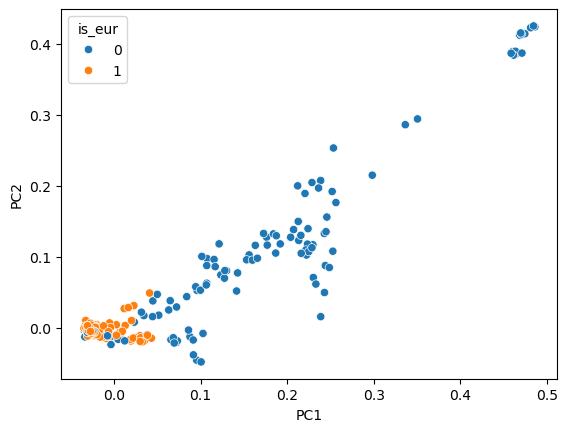

In [13]:
import seaborn as sb

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='is_eur')
fig_name = dir_fig + 'PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

In [13]:
#########################################
# generate the big table
file_name = 'combined_table.tsv'
df = get_big_table(file_name)

# or read the big table
#file_name = 'test.tsv'
#df = pd.read_table(file_name, sep='\t', header=0, keep_default_na=False)
#########################################

/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:2: DtypeWarning: Columns (48,49,50,51,52,53,54,55,59,60,61,62,63,64,65,66,71,72,73,74,75,76,77,81,82,83,84,85,86,87,88,92,93,94,95,96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


extract large ZS samples...
   zs_thr: 3, ZS_SAMPLES
   zs_thr: 5, ZS_SAMPLES
   zs_thr: 7, ZS_SAMPLES
   zs_thr: 9, ZS_SAMPLES
GNOCCHI_MAX_4...
GNOCCHI_MAX_4 subsets...
GNOCCHI_MAX_3...
GNOCCHI_MAX_3 subsets...
GNOCCHI_MAX_2...
GNOCCHI_MAX_2 subsets...
GNOCCHI_MAX_1...
GNOCCHI_MAX_1 subsets...
GNOCCHI_MEAN_4...
GNOCCHI_MEAN_4 subsets...
GNOCCHI_MEAN_3...
GNOCCHI_MEAN_3 subsets...
GNOCCHI_MEAN_2...
GNOCCHI_MEAN_2 subsets...
GNOCCHI_MEAN_1...
GNOCCHI_MEAN_1 subsets...
frequence calc...
   ZS_SAMPLES


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}_PB'] = df.apply(lambda row: get_freq(row, col, parents_set_pb), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}_ONT'] = df.apply(lambda row: get_freq(row, col, parents_set_ont), axis=1)


count number of transmissions...
   ZS_SAMPLES, gt thr: 3, add_len_thr: True, len thr: 50, supp thr: 1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 3, add_len_thr: True, len thr: 50, supp thr: 2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 3, add_len_thr: True, len thr: 50, supp thr: 3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 5, add_len_thr: True, len thr: 50, supp thr: 1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 5, add_len_thr: True, len thr: 50, supp thr: 2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 5, add_len_thr: True, len thr: 50, supp thr: 3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 7, add_len_thr: True, len thr: 50, supp thr: 1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 7, add_len_thr: True, len thr: 50, supp thr: 2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 7, add_len_thr: True, len thr: 50, supp thr: 3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 9, add_len_thr: True, len thr: 50, supp thr: 1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 9, add_len_thr: True, len thr: 50, supp thr: 2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

   ZS_SAMPLES, gt thr: 9, add_len_thr: True, len thr: 50, supp thr: 3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}_supp{supp_thr}',
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

biotype: lncRNA


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: miRNA


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: misc_RNA


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: processed_transcript


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: snoRNA


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: snRNA


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: TEC


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


biotype: protein_coding


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)


protein coding subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:255: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is

pli...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_PLI'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)


pli >0.9...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:270: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_PLIp9'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)


low pli...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_LOWPLI'] = df.apply(lambda row: xlowpli(row, pli_thr), axis=1)


loeuf...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:278: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_LOEUF'] = df.apply(lambda row: xloeuf(row, l_thr), axis=1)


ASD...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:283: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FDR_ASD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)


DD...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FDR_DD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)


NDD...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FDR_NDD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)


intergenic...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:294: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_intergenic'] = df.apply(lambda row: xintergenic(row), axis=1)


genic...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:297: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_genic'] = df.apply(lambda row: xgenic(row), axis=1)


genic subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:306: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:309: PerformanceWarning: DataFrame is highly fragmented.  This is

pli subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:315: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:318: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:324: PerformanceWarning: DataFrame is highly fragmented.  This is

pli >0.9 subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:331: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:334: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:340: PerformanceWarning: DataFrame is highly fragmented.  This is

low pli subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:350: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:356: PerformanceWarning: DataFrame is highly fragmented.  This is

loeuf subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:363: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:372: PerformanceWarning: DataFrame is highly fragmented.  This is

ASD subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:379: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:388: PerformanceWarning: DataFrame is highly fragmented.  This is

DD subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:404: PerformanceWarning: DataFrame is highly fragmented.  This is

NDD subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:414: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is

FB PR...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:425: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)


FB ENH...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)


FANTOM...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:432: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)


protein_coding CDS subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:454: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:458: PerformanceWarning: DataFrame is

brain span genes...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:466: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

dev brain genes subsets...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:476: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:479: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:485: PerformanceWarning: DataFrame is highly fragmented.  This is

dev brain and PLI...


/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:492: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:492: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
/scratch/smmortazavi/job_34477358/ipykernel_3330482/516856051.py:492: PerformanceWarning: Data

writing the output...
++++++++++++++++++++++++++++++++++++++++


In [16]:
display(df["LZS3_SAMPLES_SUPP1_Q"])
display(df.loc[df.LZS3_SAMPLES_SUPP1_Q!='']["LZS3_SAMPLES_SUPP1_Q"])

0                                                 
1                                                 
2                                                 
3                                                 
4         REACH000155:0.12|-16.12:0|-58:-58|2x0|13
                            ...                   
918552                                            
918553                                            
918554                                            
918555                                            
918556                                            
Name: LZS3_SAMPLES_SUPP1_Q, Length: 918557, dtype: object

4                  REACH000155:0.12|-16.12:0|-58:-58|2x0|13
5                   REACH000471:0.06|-19.22:0|-96:-96|1x0|7
6                 REACH000349:-13.77|0.34:-114|1:-114|1x1|8
7         REACH000411:0.73|-3.05:0|-58:-58|1x0|5,REACH00...
10                   REACH000512:0.04|-4.48:0|-53:-53|1x0|4
                                ...                        
918441    REACH000414:-0.53|3.72:-8|66:-8|5x66|1,REACH00...
918442           REACH000685:-0.50|6.57:-12|164:-12|7x164|1
918448    REACH000222:0.29|3.30:-175|-62:-175|16x-62|4,R...
918451    REACH000229:0.53|4.74:17|65:17|1x65|1,REACH000...
918452                REACH000355:2.11|3.71:40|57:40|1x57|1
Name: LZS3_SAMPLES_SUPP1_Q, Length: 310159, dtype: object

In [14]:
display(df["LZS3_SAMPLES_SUPP1_Q"])
display(df.loc[df.LZS3_SAMPLES_SUPP1_Q!='']["LZS3_SAMPLES_SUPP1_Q"])

0          
1          
2          
3          
4          
         ..
918552     
918553     
918554     
918555     
918556     
Name: LZS3_SAMPLES_SUPP1_Q, Length: 918557, dtype: object

34                  REACH000682:-0.07|3.23:3|122:3|13x122|5
38               REACH000538:0.09|-14.20:0|-166:-166|1x0|24
39        REACH000538:-6.89|0.08:-90|4:-90|1x4|24,REACH0...
41        REACH000480:0.10|-10.81:0|-137:-137|1x0|18,REA...
42        REACH000480:0.19|-8.89:0|-141:-141|1x0|13,REAC...
                                ...                        
913369              REACH000561:-8.72|-0.11:-50|0:-50|1x0|8
913375               REACH000156:-7.78|0.25:-64|2:-64|1x2|1
913479             REACH000420:-0.51|3.37:47|728:47|3x728|3
918451    REACH000661:3.51|0.62:51|18:18|30x51|10,REACH0...
918452                REACH000355:2.11|3.71:40|57:40|1x57|1
Name: LZS3_SAMPLES_SUPP1_Q, Length: 132215, dtype: object

In [15]:
display(df["LZS3_SAMPLES_SUPP2_Q"])
display(df.loc[df.LZS3_SAMPLES_SUPP1_Q!='']["LZS3_SAMPLES_SUPP2_Q"])

0                                                 
1                                                 
2                                                 
3                                                 
4         REACH000155:0.12|-16.12:0|-58:-58|2x0|13
                            ...                   
918552                                            
918553                                            
918554                                            
918555                                            
918556                                            
Name: LZS3_SAMPLES_SUPP2_Q, Length: 918557, dtype: object

4                  REACH000155:0.12|-16.12:0|-58:-58|2x0|13
5                                                          
6                                                          
7                                                          
10                                                         
                                ...                        
917537                                                     
917895           REACH000236_PB:-6.92|0.35:-98|0:-98|3x0|11
918448    REACH000222:0.29|3.30:-175|-62:-175|16x-62|4,R...
918451    REACH000661:3.51|0.62:51|18:18|30x51|10,REACH0...
918452                                                     
Name: LZS3_SAMPLES_SUPP2_Q, Length: 305384, dtype: object

In [20]:
# filter homopolymers
df_flt = df.loc[df.PERIOD>1]
print(df.shape)
print(df_flt.shape)

# filter trs based on missingness
#file_tr_ids = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/tr_ids_missingness_25.tsv'
file_tr_ids = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/tr_ids_missingness_20.tsv'
#file_tr_ids = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/tr_ids_missingness_15.tsv'
tr_miss_level = file_tr_ids.split('_')[-1].rstrip('.tsv')
print(tr_miss_level)
df_tr_ids = pd.read_table(file_tr_ids)
#df_tr_ids

df_flt = df_flt.loc[df_flt.ID.isin(df_tr_ids.tr_id)]
df_flt

(918557, 362)
(794759, 362)
20


,CHROM,POS,END,ID,GENCODE,PERIOD,ZS_SAMPLES,ZS_SAMPLES_NUM,ZS_SAMPLES_PB,ZS_SAMPLES_ONT,...,X_DEV_BR_GENE_40_cds,X_DEV_BR_GENE_40_utr,X_DEV_BR_GENE_40_intron,X_DEV_BR_GENE_50_cds,X_DEV_BR_GENE_50_utr,X_DEV_BR_GENE_50_intron,X_PLIp9_DEV_BR_GENE_10,X_PLIp9_DEV_BR_GENE_10_cds,X_PLIp9_DEV_BR_GENE_10_utr,X_PLIp9_DEV_BR_GENE_10_intron
2,chr1,15768,15879,chr1_15767_15879,exon,6,"REACH000352:-5.65|-2.06:-8|-3:-8|1x-3|2,REACH0...",9,"REACH000088:0.01|4.43:0|2:0|2x2|1,REACH000160:...","REACH000352:-3.98|-1.41:-8|-3:-8|1x-3|2,REACH0...",...,0,0,0,0,0,0,0,0,0,0
3,chr1,16683,16774,chr1_16682_16774,exon,3,"REACH000183:-0.05|4.95:0|9:0|6x9|2,REACH000185...",13,"REACH000183:-0.23|4.74:0|9:0|6x9|2,REACH000185...","REACH000414:-0.41|5.41:-1|9:-1|7x9|1,REACH0004...",...,0,0,0,0,0,0,0,0,0,0
4,chr1,19276,19473,chr1_19275_19473,.,70,"REACH000155:0.12|-16.12:0|-58:-58|2x0|13,REACH...",6,"REACH000122:-0.06|6.10:0|4:0|4x4|1,REACH000159...","REACH000155:0.19|-10.94:0|-58:-58|2x0|13,REACH...",...,0,0,0,0,0,0,0,0,0,0
5,chr1,20799,20893,chr1_20798_20893,.,18,"REACH000122:0.06|6.69:0|33:0|4x33|1,REACH00041...",4,"REACH000122:-0.07|15.66:0|33:0|4x33|1,REACH000...",REACH000471:0.12|-13.56:0|-96:-96|1x0|7,...,0,0,0,0,0,0,0,0,0,0
26,chr1,104131,104226,chr1_104130_104226,.,2,"REACH000400:-6.50|1.75:-32|15:-32|1x15|1,REACH...",9,.,"REACH000400:-4.87|1.47:-32|15:-32|1x15|1,REACH...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918451,chrY,56867432,56867522,chrY_56867431_56867522,.,2,"REACH000026:-0.17|7.89:9|101:9|20x101|2,REACH0...",8,"REACH000026:-0.17|6.99:9|101:9|20x101|2,REACH0...",REACH000661:4.55|0.84:51|18:18|30x51|10,...,0,0,0,0,0,0,0,0,0,0
918452,chrY,56871602,56871681,chrY_56871601_56871681,.,2,REACH000355:2.11|3.71:40|57:40|1x57|1,1,REACH000355:2.02|3.53:40|57:40|1x57|1,.,...,0,0,0,0,0,0,0,0,0,0
918453,chrY,56873335,56873435,chrY_56873334_56873435,.,2,.,.,.,.,...,0,0,0,0,0,0,0,0,0,0
918455,chrY,56878180,56878308,chrY_56878179_56878308,.,2,.,.,.,.,...,0,0,0,0,0,0,0,0,0,0


In [38]:
zs_thr = 3.5
len_thr = 50
supp_thr = 3
col = 'ZS_SAMPLES'
df[[f'denovo_ZS{zs_thr}_len{len_thr}_supp{supp_thr}',
    f'denovoDADs_ZS{zs_thr}_len{len_thr}_supp{supp_thr}', 
    f'denovoMOMs_ZS{zs_thr}_len{len_thr}_supp{supp_thr}', 
    f'denovoPLAT_ZS{zs_thr}_len{len_thr}_supp{supp_thr}']] = df.apply(
                    lambda row: get_denovo(row, col, sample_mom_dict, sample_dad_dict,
                                               gt_thr=zs_thr, len_thr=len_thr, supp_thr=supp_thr), 
                         axis=1, result_type='expand')

In [39]:
cols_base = ['CHROM', 'POS', 'END', 'ID', 'GENCODE', 'PERIOD', 'SYMBOL', 'GENE', 'GENES_PLI', 
             'MAX_PLI', 'MAX_PLI_GENE', 'SIG_PLIS', 'SIG_PLI_GENES']
cols = [f'denovo_ZS{zs_thr}_len{len_thr}_supp{supp_thr}',
    f'denovoDADs_ZS{zs_thr}_len{len_thr}_supp{supp_thr}', 
    f'denovoMOMs_ZS{zs_thr}_len{len_thr}_supp{supp_thr}', 
    f'denovoPLAT_ZS{zs_thr}_len{len_thr}_supp{supp_thr}']
this_df = df.loc[ (df[f'denovo_ZS{zs_thr}_len{len_thr}_supp{supp_thr}'] != '')][cols_base + cols]
this_df_pb = this_df.loc[this_df[f'denovoPLAT_ZS{zs_thr}_len{len_thr}_supp{supp_thr}'].str.contains('PB')]

display(this_df)
display(this_df_pb)

file_out = 'investigate_denovo.tsv'
print(file_out)
this_df.to_csv(file_out, sep='\t', index=None)

file_out = 'investigate_denovo_pb.tsv'
print(file_out)
this_df_pb.to_csv(file_out, sep='\t', index=None)

,CHROM,POS,END,ID,GENCODE,PERIOD,SYMBOL,GENE,GENES_PLI,MAX_PLI,MAX_PLI_GENE,SIG_PLIS,SIG_PLI_GENES,denovo_ZS3.5_len50_supp3,denovoDADs_ZS3.5_len50_supp3,denovoMOMs_ZS3.5_len50_supp3,denovoPLAT_ZS3.5_len50_supp3
34,chr1,120938,121168,chr1_120937_121168,.,7,".,.","ENSG00000238009,ENSG00000238009",".,.",-1.000000,.,,,REACH000479:-0.16|4.84:0|180:0|24x180|3,REACH000481,REACH000480,ONT
39,chr1,134036,134124,chr1_134035_134124,exon,1,"CICP27,.,.,.","ENSG00000233750,ENSG00000268903,ENSG0000026998...",".,.,.,.",-1.000000,.,,,REACH000568:-0.37|3.79:-2|54:-2|15x54|5,REACH000566,REACH000565,ONT
69,chr1,273572,273682,chr1_273571_273682,.,6,".,.","ENSG00000228463,ENSG00000286448",".,.",-1.000000,.,,,REACH000766:0.29|-3.50:0|-112:-112|4x0|10,REACH000764,REACH000763,PB
196,chr1,727156,727603,chr1_727155_727603,exon,32,"CICP3,.,.","ENSG00000229376,ENSG00000291215,ENSG00000230021",".,.,.",-1.000000,.,,,REACH000426:-0.32|4.52:0|1564:0|9x1564|3,REACH000425,REACH000424,ONT
197,chr1,728239,728368,chr1_728238_728368,exon,33,"CICP3,.,.","ENSG00000229376,ENSG00000291215,ENSG00000230021",".,.,.",-1.000000,.,,,"REACH000510:0.12|-9.42:0|-131:-131|3x0|13,REAC...","REACH000512,REACH000512","REACH000511,REACH000511","ONT,ONT"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866896,chrX,2437634,2437764,chrX_2437633_2437764,.,2,DHRSX,ENSG00000169084,1.3476e-02,0.013476,DHRSX,,,REACH000547:-11.28|-1.20:-86|-22:-86|3x-22|4,REACH000546,REACH000545,ONT
866936,chrX,2517719,2518026,chrX_2517718_2518026,.,4,.,.,.,-1.000000,.,,,REACH000564:-7.85|-1.17:-73|-13:-73|7x-13|2,REACH000566,REACH000565,ONT
867050,chrX,2749070,2749407,chrX_2749069_2749407,dELS,4,"XG,XG,XG,XG","ENSG00000124343,ENSG00000124343,ENSG0000012434...","2.6788e-05,2.6788e-05,2.6788e-05,2.6788e-05",0.000027,XG,,,REACH000564:0.28|-15.66:0|-281:-281|3x0|7,REACH000566,REACH000565,ONT
913363,chrY,11103961,11104202,chrY_11103960_11104202,.,6,".,.,.","ENSG00000270570,ENSG00000271309,ENSG00000271365",".,.,.",-1.000000,.,,,"REACH000095:0.30|-3.59:0|-243:-243|3x0|7,REACH...","REACH000094,REACH000437,REACH000503","REACH000093,REACH000436_PB,REACH000502","PB,ONT,ONT"


,CHROM,POS,END,ID,GENCODE,PERIOD,SYMBOL,GENE,GENES_PLI,MAX_PLI,MAX_PLI_GENE,SIG_PLIS,SIG_PLI_GENES,denovo_ZS3.5_len50_supp3,denovoDADs_ZS3.5_len50_supp3,denovoMOMs_ZS3.5_len50_supp3,denovoPLAT_ZS3.5_len50_supp3
69,chr1,273572,273682,chr1_273571_273682,.,6,".,.","ENSG00000228463,ENSG00000286448",".,.",-1.000000e+00,.,,,REACH000766:0.29|-3.50:0|-112:-112|4x0|10,REACH000764,REACH000763,PB
12899,chr1,35640530,35640808,chr1_35640529_35640808,pELS,109,PSMB2,ENSG00000126067,4.0315e-01,4.031500e-01,PSMB2,,,REACH000747:-8.53|0.14:-109|0:-109|3x0|3,REACH000749,REACH000748,PB
27604,chr1,83182834,83182920,chr1_83182833_83182920,.,7,.,.,.,-1.000000e+00,.,,,REACH000292:0.13|-9.17:0|-92:-92|3x0|5,REACH000290,REACH000289,PB
224051,chr4,55961735,55961825,chr4_55961734_55961825,.,1,"CEP135,CEP135","ENSG00000174799,ENSG00000174799","1.6526e-07,1.6526e-07",1.652600e-07,CEP135,,,REACH000367:19.83|-0.06:847|-1:-1|3x847|3,REACH000366,REACH000365,PB
245702,chr4,126561238,126561360,chr4_126561237_126561360,.,2,"RBM48P1,.","ENSG00000223620,ENSG00000286251",".,.",-1.000000e+00,.,,,REACH000316:3.72|3.72:51|51:51|5,REACH000315,REACH000314,PB
264826,chr4,187120589,187120691,chr4_187120588_187120691,.,2,.,.,.,-1.000000e+00,.,,,REACH000316:-5.63|0.35:-92|12:-92|3x12|2,REACH000315,REACH000314,PB
266213,chr5,751275,751634,chr5_751274_751634,.,19,ZDHHC11B,ENSG00000206077,4.7082e-01,4.708200e-01,ZDHHC11B,,,"REACH000092:0.40|4.73:-4|164:-4|7x164|7,REACH0...","REACH000094,REACH000094","REACH000093,REACH000093","PB,PB"
272816,chr5,21490819,21490912,chr5_21490818_21490912,.,13,"GUSBP1,GUSBP1,GUSBP1,.,GUSBP1","ENSG00000183666,ENSG00000291102,ENSG0000029110...",".,.,.,.,.",-1.000000e+00,.,,,"REACH000233:0.12|-4.55:0|-95:-95|4x0|1,REACH00...","REACH000235,REACH000290,REACH000546,REACH00066...","REACH000234,REACH000289,REACH000545,REACH00066...","PB,PB,ONT,ONT,PB"
272817,chr5,21491156,21491241,chr5_21491155_21491241,.,1,"GUSBP1,GUSBP1,GUSBP1,.,GUSBP1","ENSG00000183666,ENSG00000291102,ENSG0000029110...",".,.,.,.,.",-1.000000e+00,.,,,"REACH000233:0.22|-4.65:0|-87:-87|4x0|1,REACH00...","REACH000235,REACH000290,REACH000546,REACH00066...","REACH000234,REACH000289,REACH000545,REACH00066...","PB,PB,ONT,ONT,PB"
272818,chr5,21491633,21491739,chr5_21491632_21491739,.,4,"GUSBP1,GUSBP1,GUSBP1,.,GUSBP1","ENSG00000183666,ENSG00000291102,ENSG0000029110...",".,.,.,.,.",-1.000000e+00,.,,,"REACH000233:0.63|-4.54:8|-108:-108|4x8|1,REACH...","REACH000235,REACH000290,REACH000662,REACH000707","REACH000234,REACH000289,REACH000661,REACH000706","PB,PB,ONT,PB"


investigate_denovo.tsv
investigate_denovo_pb.tsv


In [16]:
def is_close(kid_gt, par_gts, err_thr=0.2):
    err_min = np.min([abs((kid_gt-par_gt) / (par_gt+.001)) for par_gt in par_gts])
    if err_min <= err_thr:
        return True
    return False
    
def get_denovo(row, col, sample_mom_dict, sample_dad_dict, gt_thr=0, len_thr=0, supp_thr=1):
    q_samples = [x.split(':')[0] for x in row['Q90_SAMPLES_GB'].split(',') if x != '.']
    hp1_samples = [x.split(':')[0] for x in row['HP1_SAMPLES_PDP'].split(',') if x != '.']
    hp2_samples = [x.split(':')[0] for x in row['HP2_SAMPLES_PDP'].split(',') if x != '.']
    #hem_samples = [x.split(':')[0] for x in row['HEM_SAMPLES_DP'].split(',') if x != '.']

    kids = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in sample_mom_dict]
    
    moms = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in mom_kids_dict]
    dads = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in dad_kids_dict]
    mom_mates = [mate_dict[x] for x in moms]
    dad_mates = [mate_dict[x] for x in dads]
    mom_kids = [mom_kids_dict[x] for x in moms]
    dad_kids = [dad_kids_dict[x] for x in dads]


    sample_gt_dict = {x.split(':')[0]: (float(x.split(':')[1].split('|')[0]), float(x.split(':')[1].split('|')[1])) 
                      if ((x != '.') and (len(x.split(':')[1].split('|'))==2)) 
                      else ((float(x.split(':')[1].split('|')[0]),) if ((x != '.') and (len(x.split(':')[1].split('|'))==1)) else '.')
                      for x in row[col].split(',')}
    sample_len_dict = {x.split(':')[0]: (int(x.split(':')[2].split('|')[0]), int(x.split(':')[2].split('|')[1])) 
                      if ((x != '.') and (len(x.split(':')[2].split('|'))==2)) 
                      else ((int(x.split(':')[2].split('|')[0]),) if ((x != '.') and (len(x.split(':')[2].split('|'))==1)) else '.')
                      for x in row[col].split(',')}

    sample_supp_dict = {x.split(':')[0]: {int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1]), 
                                           int(x.split(':')[-1].split('x')[1].split('|')[0]): int(x.split(':')[-1].split('x')[1].split('|')[1])} 
                        if ((x != '.') and (len(x.split(':')[-1].split('x'))==2)) 
                        else ({int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1])} 
                              if ((x != '.') and (len(x.split(':')[-1].split('x'))==1)) else '.') for x in row[col].split(',')}
    sample_info_dict = {x.split(':')[0]: x for x in row[col].split(',')}

    dn_kids = []
    dn_dads = []
    dn_moms = []
    dn_plat = []
    for kid in kids:
        kid_gts = sample_gt_dict[kid]
        kid_lens = sample_len_dict[kid]
        kid_supp = sample_supp_dict[kid]
        gt_good = False
        for gt, l in zip(kid_gts, kid_lens):
            supp = kid_supp[l]
            if (abs(gt) >= gt_thr) and (supp >= supp_thr) and (abs(l) >= len_thr):
                gt_good = True
        if (not gt_good):
            continue

        dad = sample_dad_dict[kid]
        mom = sample_mom_dict[kid]

        # make sure mom and dad have at least one read in each phase
        if (mom not in hp1_samples) or (mom not in hp2_samples) or (dad not in hp1_samples) or (dad not in hp2_samples):
            continue

        dad_gts = None
        if dad in sample_gt_dict:
            dad_gts = sample_gt_dict[dad]
        mom_gts = None
        if mom in sample_gt_dict:
            mom_gts = sample_gt_dict[mom]

        is_denovo = False
        for gt, l in zip(kid_gts, kid_lens):
            supp = kid_supp[l]
            if (abs(gt) >= gt_thr) and (supp >= supp_thr) and (abs(l) >= len_thr):
                if (dad_gts==None or (not is_close(gt, dad_gts))) and (mom_gts==None or (not is_close(gt, mom_gts))):
                    is_denovo = True
        if is_denovo:
            dn_kids.append(sample_info_dict[kid])
            dn_dads.append(sample_info_dict[dad] if dad in sample_info_dict else dad)
            dn_moms.append(sample_info_dict[mom] if mom in sample_info_dict else mom)
            dn_plat.append(plat_dict[kid])

    return ','.join(dn_kids), ','.join(dn_dads), ','.join(dn_moms), ','.join(dn_plat)

In [6]:
def is_close(kid_gt, par_gts, err_thr=0.2):
    err_min = np.min([abs((kid_gt-par_gt) / (par_gt+.001)) for par_gt in par_gts])
    if err_min <= err_thr:
        return True
    return False

def get_denovo(row, col, mom_kids_dict, dad_kids_dict, parent_kids_dict, mate_dict ,aff_dict, gt_thr=0, add_len_thr=False, 
              len_thr=0, plat=None, supp_thr=2):
    num_tran_case = 0
    num_tran_control = 0
    num_nontran_case = 0
    num_nontran_control = 0
    tran_list = []
    nontran_list = []
    #if row['CHROM'] == 'chrX' or row['CHROM'] == 'chrY':
    #    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control, '', ''
    q_samples = [x.split(':')[0] for x in row['Q90_SAMPLES_GB'].split(',') if x != '.']
    hp1_samples = [x.split(':')[0] for x in row['HP1_SAMPLES_PDP'].split(',') if x != '.']
    hp2_samples = [x.split(':')[0] for x in row['HP2_SAMPLES_PDP'].split(',') if x != '.']
    hem_samples = [x.split(':')[0] for x in row['HEM_SAMPLES_DP'].split(',') if x != '.']
    
    moms = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in mom_kids_dict]
    dads = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in dad_kids_dict]
    mom_mates = [mate_dict[x] for x in moms]
    dad_mates = [mate_dict[x] for x in dads]
    mom_kids = [mom_kids_dict[x] for x in moms]
    dad_kids = [dad_kids_dict[x] for x in dads]
    
    if 'LARGE' in col:
        #sample_gt_dict = {x.split(':')[0]:(int(x.split(':')[1].split('|')[0]), int(x.split(':')[1].split('|')[1])) 
        #                  for x in row[col].split(',') if x != '.'}
        sample_gt_dict = {x.split(':')[0]: (int(x.split(':')[1].split('|')[0]), int(x.split(':')[1].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[1].split('|'))==2)) 
                          else ((int(x.split(':')[1].split('|')[0]),) if ((x != '.') and (len(x.split(':')[1].split('|'))==1)) else '.')
                          for x in row[col].split(',')}
        sample_len_dict = sample_gt_dict
    elif 'ZS_' in col:
        #sample_gt_dict = {x.split(':')[0]:(float(x.split(':')[1].split('|')[0]), float(x.split(':')[1].split('|')[1])) 
        #                  for x in row[col].split(',') if x != '.'}
        #sample_len_dict = {x.split(':')[0]:(int(x.split(':')[2].split('|')[0]), int(x.split(':')[2].split('|')[1])) 
        #                   for x in row[col].split(',') if x != '.'}
        sample_gt_dict = {x.split(':')[0]: (float(x.split(':')[1].split('|')[0]), float(x.split(':')[1].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[1].split('|'))==2)) 
                          else ((float(x.split(':')[1].split('|')[0]),) if ((x != '.') and (len(x.split(':')[1].split('|'))==1)) else '.')
                          for x in row[col].split(',')}
        sample_len_dict = {x.split(':')[0]: (int(x.split(':')[2].split('|')[0]), int(x.split(':')[2].split('|')[1])) 
                          if ((x != '.') and (len(x.split(':')[2].split('|'))==2)) 
                          else ((int(x.split(':')[2].split('|')[0]),) if ((x != '.') and (len(x.split(':')[2].split('|'))==1)) else '.')
                          for x in row[col].split(',')}

    sample_supp_dict = {x.split(':')[0]: {int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1]), 
                                           int(x.split(':')[-1].split('x')[1].split('|')[0]): int(x.split(':')[-1].split('x')[1].split('|')[1])} 
                        if ((x != '.') and (len(x.split(':')[-1].split('x'))==2)) 
                        else ({int(x.split(':')[-1].split('x')[0].split('|')[0]): int(x.split(':')[-1].split('x')[0].split('|')[1])} 
                              if ((x != '.') and (len(x.split(':')[-1].split('x'))==1)) else '.') for x in row[col].split(',')}

    #print(f'moms:{moms}')
    #print(f'dads:{dads}')
    #print(f'mom_mates: {mom_mates}')
    #print(f'dad_mates: {dad_mates}')
    #print(f'mom_kids: {mom_kids}')
    #print(f'dad_kids: {dad_kids}')
    #print(f'sample_gt_dict: {sample_gt_dict}')
    #print(f'sample_len_dict: {sample_len_dict}')
    #print(f'sample_supp_dict: {sample_supp_dict}')

    parss = [moms, dads]
    par_matess = [mom_mates, dad_mates]
    par_kidss = [mom_kids, dad_kids]
    par_hp_idxs = [1, 0]
    other_par_hp_idxs = [0, 1]

    for pars, par_mates, par_kids, par_hp_idx, other_par_hp_idx in zip(parss, par_matess, par_kidss, par_hp_idxs, other_par_hp_idxs):
        for par1, par2, kids in zip(pars, par_mates, par_kids):
            par1_gts = sample_gt_dict[par1]
            par1_lens = sample_len_dict[par1]
            par1_supp = sample_supp_dict[par1]
            gt_good = False
            for gt, l in zip(par1_gts, par1_lens):
                supp = par1_supp[l]
                #if (abs(gt) >= gt_thr) and (supp>=supp_thr) and (par1 in q_samples):
                if (abs(gt) >= gt_thr) and (supp>=supp_thr):
                    gt_good = True
                    #print('THIS IS GOOD GT...')
            if (not gt_good):
                continue
            #if np.max(np.abs(par1_gts)) < gt_thr:
            #    continue
            if add_len_thr and (np.max(np.abs(sample_len_dict[par1])) < len_thr):
                continue
            if (plat!=None) and (plat_dict[par1]!=plat):
                continue
            for k in kids:
                if k in sample_gt_dict:
                    kid_gts = sample_gt_dict[k]
                    # if variant is on chrX or chrY and kid is male we have one genotype
                    if len(kid_gts) == 1:
                        if (abs(kid_gts[0]) >= gt_thr*.8) and is_close(kid_gts[0], par1_gts):
                            if aff_dict[k] == 'Yes':
                                num_tran_case += 1
                            elif aff_dict[k] == 'No':
                                num_tran_control += 1
                            tran_list.append(k)
                        elif k in hem_samples:
                            if aff_dict[k] == 'Yes':
                                num_nontran_case += 1
                            elif aff_dict[k] == 'No':
                                num_nontran_control += 1
                            nontran_list.append(k)
                        continue
                    if (abs(kid_gts[par_hp_idx]) >= gt_thr*.8) and is_close(kid_gts[par_hp_idx], par1_gts):
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                        tran_list.append(k)
                    elif (abs(kid_gts[other_par_hp_idx]) >= gt_thr*.8) and is_close(kid_gts[other_par_hp_idx], par1_gts):
                        if (par2 not in sample_gt_dict):
                            if aff_dict[k] == 'Yes':
                                num_tran_case += 1
                            elif aff_dict[k] == 'No':
                                num_tran_control += 1
                            tran_list.append(k)
                        else:
                            par2_gts = sample_gt_dict[par2]
                            if (not is_close(kid_gts[other_par_hp_idx], par2_gts)):
                                if aff_dict[k] == 'Yes':
                                    num_tran_case += 1
                                elif aff_dict[k] == 'No':
                                    num_tran_control += 1
                                tran_list.append(k)
                    elif ((k in hp1_samples) and (k in hp2_samples)) or (k in hem_samples):
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 1
                        nontran_list.append(k)
                elif ((k in hp1_samples) and (k in hp2_samples)) or (k in hem_samples):
                    if aff_dict[k] == 'Yes':
                        num_nontran_case += 1
                    elif aff_dict[k] == 'No':
                        num_nontran_control += 1
                    nontran_list.append(k)

    tran_str = ','.join(tran_list)
    nontran_str = ','.join(nontran_list)

    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control, tran_str, nontran_str

notebook_trs/hist_samples_genotyped.png


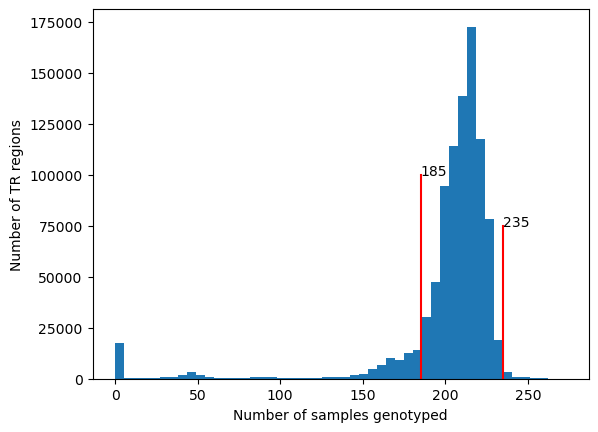

In [16]:
# plot histogram of the number of samples genotyped
plt.figure()
plt.hist(df.SN_GB, bins=50)
x_lim = 185
y_lim = 100000
plt.plot([x_lim, x_lim], [0, y_lim], '-r')
plt.text(x_lim, y_lim, f'{x_lim}')

x_lim = 235
y_lim = 75000
plt.plot([x_lim, x_lim], [0, y_lim], '-r')
plt.text(x_lim, y_lim, f'{x_lim}')

#plt.plot([60, 60], [0, 75000], '--r')
#plt.text(60, 75000, '60')
plt.xlabel('Number of samples genotyped')
plt.ylabel('Number of TR regions')
fig_name = dir_fig+'hist_samples_genotyped.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

notebook_trs/hist_samples_genotyped.png


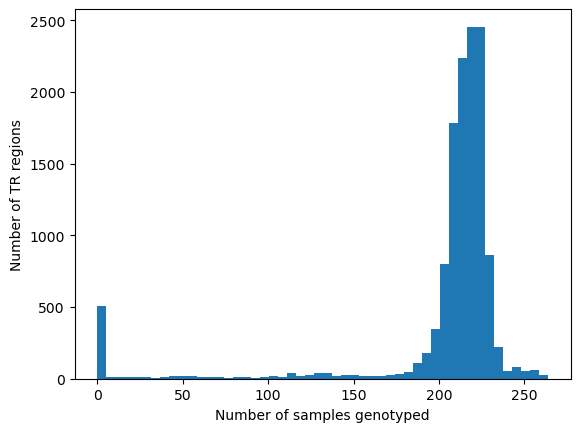

In [19]:
# plot histogram of the number of samples genotyped
# chr22 only
plt.figure()
plt.hist(df.SN_GB, bins=50)
x_lim = 185
y_lim = 100000
#plt.plot([x_lim, x_lim], [0, y_lim], '-r')
#plt.text(x_lim, y_lim, f'{x_lim}')

x_lim = 235
y_lim = 75000
#plt.plot([x_lim, x_lim], [0, y_lim], '-r')
#plt.text(x_lim, y_lim, f'{x_lim}')

#plt.plot([60, 60], [0, 75000], '--r')
#plt.text(60, 75000, '60')
plt.xlabel('Number of samples genotyped')
plt.ylabel('Number of TR regions')
fig_name = dir_fig+'hist_samples_genotyped.png'
print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

notebook_trs/hist_zscore.png


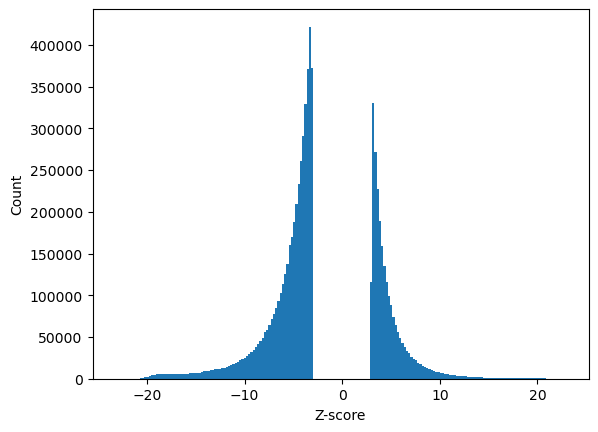

In [17]:
file_name = 'output/zs_large_3.txt'
df_zs = pd.read_table(file_name, sep='\t', names=['ID', 'Z-score', 'GB', 'sample_id'])
#display(df_zs)
plt.figure()
plt.hist(df_zs['Z-score'], bins=200)
plt.xlabel('Z-score')
plt.ylabel('Count')
fig_name = dir_fig+'hist_zscore.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

notebook_trs/hist_zscore.png


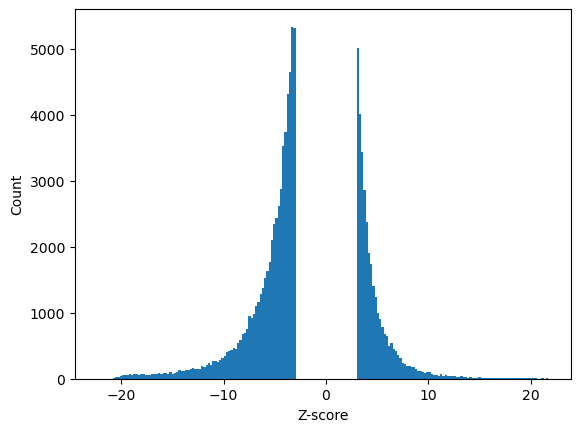

In [20]:
# chr22 only
file_name = 'output/zs_large_3.txt'
df_zs = pd.read_table(file_name, sep='\t', names=['ID', 'Z-score', 'GB', 'sample_id'])
#display(df_zs)
plt.figure()
plt.hist(df_zs['Z-score'], bins=200)
plt.xlabel('Z-score')
plt.ylabel('Count')
fig_name = dir_fig+'hist_zscore.png'
print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [18]:
biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
pc_subsec = ['protein_coding_cds', 'protein_coding_utr', 'protein_coding_intron', 
             'protein_coding_cds_pli', 'protein_coding_cds_loeuf', 
             'protein_coding_cds_fdr_asd', 'protein_coding_cds_fdr_dd', 'protein_coding_cds_fdr_ndd']
consts_1 = ['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'intergenic', 'genic']
consts_2 = ['FB_PR', 'FB_ENH', 'FANTOM']
consts_3 = ['GNOCCHI_MAX_1', 'GNOCCHI_MAX_2', 'GNOCCHI_MAX_3', 'GNOCCHI_MAX_4', 
            'GNOCCHI_MEAN_1', 'GNOCCHI_MEAN_2', 'GNOCCHI_MEAN_3', 'GNOCCHI_MEAN_4']
#consts_3_subsec = ['GNOCCHI_MAX_4_cds', 'GNOCCHI_MAX_4_utr', 'GNOCCHI_MAX_4_intron', 
#                   'GNOCCHI_MAX_3_cds', 'GNOCCHI_MAX_3_utr', 'GNOCCHI_MAX_3_intron', 
#                   'GNOCCHI_MAX_2_cds', 'GNOCCHI_MAX_2_utr', 'GNOCCHI_MAX_2_intron']
#consts_4 = ['EV_CONS_EL_BP_1', 'EV_CONS_EL_BP_50', 'EV_CONS_EL_BP_100', 
#            'EV_CONS_EL_FRAC_2', 'EV_CONS_EL_FRAC_5', 'EV_CONS_EL_FRAC_10', 'S_HET_1', 'S_HET_10', 'S_HET_100']
#consts_4_subsec1 = ['EV_CONS_EL_BP_1_cds', 'EV_CONS_EL_BP_1_utr', 'EV_CONS_EL_BP_1_ncd', 
#                   'EV_CONS_EL_BP_50_cds', 'EV_CONS_EL_BP_50_utr', 'EV_CONS_EL_BP_50_ncd', 
#                   'EV_CONS_EL_BP_100_cds', 'EV_CONS_EL_BP_100_utr', 'EV_CONS_EL_BP_100_ncd',
#                   'S_HET_1_cds', 'S_HET_1_utr', 'S_HET_1_intron', 
#                    'S_HET_10_cds', 'S_HET_10_utr', 'S_HET_10_intron', 
#                    'S_HET_100_cds', 'S_HET_100_utr', 'S_HET_100_intron']
#consts_4_subsec2 = ['EV_CONS_EL_FRAC_2_cds', 'EV_CONS_EL_FRAC_2_utr', 'EV_CONS_EL_FRAC_2_ncd', 
#                   'EV_CONS_EL_FRAC_5_cds', 'EV_CONS_EL_FRAC_5_utr', 'EV_CONS_EL_FRAC_5_ncd', 
#                   'EV_CONS_EL_FRAC_10_cds', 'EV_CONS_EL_FRAC_10_utr', 'EV_CONS_EL_FRAC_10_ncd']
consts_subsec_1 = ['PLI_cds', 'PLI_utr', 'PLI_intron', 
                   'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron', 
                   'genic_cds', 'genic_utr', 'genic_intron']
consts_subsec_2 = ['FDR_ASD_cds', 'FDR_ASD_utr', 'FDR_ASD_intron', 
                   'FDR_DD_cds', 'FDR_DD_utr', 'FDR_DD_intron', 
                   'FDR_NDD_cds', 'FDR_NDD_utr', 'FDR_NDD_intron']
consts_subsec_3 = ['PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron',
                   'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
dev_br_10 = ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']
#dev_br_20 = ['DEV_BR_GENE_20', 'DEV_BR_GENE_20_cds', 'DEV_BR_GENE_20_utr', 'DEV_BR_GENE_20_intron']
#dev_br_30 = ['DEV_BR_GENE_30', 'DEV_BR_GENE_30_cds', 'DEV_BR_GENE_30_utr', 'DEV_BR_GENE_30_intron']
#dev_br_40 = ['DEV_BR_GENE_40', 'DEV_BR_GENE_40_cds', 'DEV_BR_GENE_40_utr', 'DEV_BR_GENE_40_intron']
#dev_br_50 = ['DEV_BR_GENE_50', 'DEV_BR_GENE_50_cds', 'DEV_BR_GENE_50_utr', 'DEV_BR_GENE_50_intron']
dev_br_pli = ['PLIp9_DEV_BR_GENE_10', 'PLIp9_DEV_BR_GENE_10_cds', 'PLIp9_DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_intron']

In [21]:
#fts = (biotypes + pc_subsec + consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + consts_subsec_3 +
#       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50)
fts = (consts_1 + consts_2 + consts_3 + consts_subsec_1 + consts_subsec_2 + consts_subsec_3 +
       dev_br_10 + dev_br_pli)

print(df_flt.shape)
df_main = pd.DataFrame(df_pca_flt)
for ft in fts:
    print(ft)
    #this_df = df.loc[df[f'X_{ft}'] == 1]
    ### for filtering TRs based on missingness
    this_df = df_flt.loc[df_flt[f'X_{ft}'] == 1]
    for zs_thr in lzs_thrs:
        samples_col = f'LZS{zs_thr}_SAMPLES'
        temp = this_df[samples_col].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend([xx.split(':')[0] for xx in x])
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_ZS{zs_thr}_{ft}'] = count_col

        samples_col = f'LZS{zs_thr}_SAMPLES_Q'
        temp = this_df[samples_col].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend([xx.split(':')[0] for xx in x])
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col

        for supp_thr in supp_thrs:
            samples_col = f'LZS{zs_thr}_SAMPLES_SUPP{supp_thr}'
            temp = this_df[samples_col].str.split(',').tolist()
            this_samples_list = []
            for x in temp:
                this_samples_list.extend([xx.split(':')[0] for xx in x])
            count_col = []
            for sample in df_pca_flt.iid.tolist():
                count_col.append(this_samples_list.count(sample))
            df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col

            samples_col = f'LZS{zs_thr}_SAMPLES_SUPP{supp_thr}_Q'
            temp = this_df[samples_col].str.split(',').tolist()
            this_samples_list = []
            for x in temp:
                this_samples_list.extend([xx.split(':')[0] for xx in x])
            count_col = []
            for sample in df_pca_flt.iid.tolist():
                count_col.append(this_samples_list.count(sample))
            df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
        

display(df_main)
#file_out = 'main_df_toR_ZS3_5_7_9_len50.csv'
### for filtering TRs based on missingness
file_out = f'main_df_toR_ZS3_5_7_9_len50_TRmissingness{tr_miss_level}_fltHomPol_famGT.csv'
print(f'writing {file_out}')
df_main.to_csv(file_out, sep=',', header=True, index=False)

(432523, 362)
PLI
LOEUF
FDR_ASD


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

FDR_DD


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

FDR_NDD


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

intergenic


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

genic


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FB_PR


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FB_ENH


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FANTOM


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

GNOCCHI_MAX_1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MAX_2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MAX_3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MAX_4


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MEAN_1


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MEAN_2


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MEAN_3


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

GNOCCHI_MEAN_4


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

PLI_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

PLI_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

PLI_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

LOEUF_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

LOEUF_utr
LOEUF_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

genic_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

genic_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

genic_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FDR_ASD_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FDR_ASD_utr
FDR_ASD_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

FDR_DD_cds
FDR_DD_utr
FDR_DD_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

FDR_NDD_cds
FDR_NDD_utr
FDR_NDD_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

PLIp9_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

PLIp9_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

PLIp9_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

LOWPLI_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

LOWPLI_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

LOWPLI_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

DEV_BR_GENE_10


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

DEV_BR_GENE_10_cds


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

DEV_BR_GENE_10_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

DEV_BR_GENE_10_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

PLIp9_DEV_BR_GENE_10


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

PLIp9_DEV_BR_GENE_10_cds
PLIp9_DEV_BR_GENE_10_utr


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

PLIp9_DEV_BR_GENE_10_intron


/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_Q'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}_SUPP{supp_thr}'] = count_col
/scratch/smmortazavi/job_34477358/ipykernel_3330482/425757085.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,count_ZS7_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS7_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,1,1,37,34,37,34,10,8,0,0
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,0,0,0,0,0,0,0,0,0,0
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0,0,0,0,0,0,0,0,0,0
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0,0,0,0,0,0,0,0,0,0
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,0,0,0,0,0,0,0,0,0,0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,0,0,0,0,0,0,0,0,0,0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,0,0,0,0,0,0,0,0,0,0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,0,0,0,0,0,0,0,0,0,0


writing main_df_toR_ZS3_5_7_9_len50_TRmissingness20_fltHomPol_famGT.csv


In [22]:
# after alignment weight change, All chroms, supp≥3, len50
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len50.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len50.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len50.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len50.sum())

col = 'ZS_SAMPLES_gt5_len50'
file_out = f'data_tables/table_nonZeroTR_{col}_supp{supp_thr}_len{len_thr_gl}.tsv'
print(file_out)
df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
18083
20522 nontran/tran: 1.134878062268429
10290
12190
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
5243
6357 nontran/tran: 1.2124737745565517
2948
3758
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
2481
2918 nontran/tran: 1.1761386537686416
1397
1655
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
1323
1687 nontran/tran: 1.2751322751322751
797
930
data_tables/table_nonZeroTR_ZS_SAMPLES_gt5_len50_supp3_len50.tsv


In [21]:
# after alignment weight change, All chroms, supp>=3, len50
# PB,
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len50.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len50.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len50.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len50.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT,
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len50.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len50.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len50.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len50.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
4809
3966 nontran/tran: 0.8247036805988771
3099
2696
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
1351
1286 nontran/tran: 0.9518874907475944
872
862
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
596
698 nontran/tran: 1.1711409395973154
413
427
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
205
437 nontran/tran: 2.131707317073171
164
252
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
11659
14533 nontran/tran: 1.2465048460416845
6390
8376
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
3034
3839 nontran/tran: 1.2653263019116678
1590
2087
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
1025
1622 nontran/tran: 1.582439024390244
572
859
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
250
741 nontran/tran: 2.964
121
395


In [15]:
# chr22, supp≥2
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
1431
6187 nontran/tran: 4.323549965059399
957
3792
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
554
2388 nontran/tran: 4.310469314079422
359
1437
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
393
1393 nontran/tran: 3.544529262086514
233
858
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
279
997 nontran/tran: 3.5734767025089607
157
622


In [23]:
# chr22 after alignment weight change, supp≥2
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

col = 'ZS_SAMPLES_gt5_len25'
file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
print(file_out)
df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
1134
4925 nontran/tran: 4.343033509700176
785
3122
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
223
1407 nontran/tran: 6.309417040358745
169
938
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
83
649 nontran/tran: 7.819277108433735
77
429
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
38
367 nontran/tran: 9.657894736842104
43
272
data_tables/table_nonZeroTR_ZS_SAMPLES_gt5_len25.tsv


In [14]:
# chr22 after alignment weight change, supp≥3
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

col = 'ZS_SAMPLES_gt5_len25'
file_out = f'data_tables/table_nonZeroTR_{col}_supp{supp_thr}.tsv'
print(file_out)
df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
764
1853 nontran/tran: 2.425392670157068
528
1115
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
135
292 nontran/tran: 2.162962962962963
118
176
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
57
117 nontran/tran: 2.0526315789473686
60
70
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
30
62 nontran/tran: 2.066666666666667
38
39
data_tables/table_nonZeroTR_ZS_SAMPLES_gt5_len25_supp3.tsv


In [14]:
# chr22 after alignment weight change, supp≥3, Q samples
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

col = 'ZS_SAMPLES_gt5_len25'
file_out = f'data_tables/table_nonZeroTR_{col}_supp{supp_thr}_Q.tsv'
print(file_out)
df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
632
1466 nontran/tran: 2.319620253164557
440
894
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
105
224 nontran/tran: 2.1333333333333333
110
151
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
46
95 nontran/tran: 2.0652173913043477
58
57
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
23
55 nontran/tran: 2.391304347826087
37
33
data_tables/table_nonZeroTR_ZS_SAMPLES_gt5_len25_supp3_Q.tsv


In [17]:
# chr22 after alignment weight change, supp≥3, Q samples, len50
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len50.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len50.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len50.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len50.sum())

col = 'ZS_SAMPLES_gt5_len50'
file_out = f'data_tables/table_nonZeroTR_{col}_supp{supp_thr}_Q_len{len_thr_gl}.tsv'
print(file_out)
df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
396
435 nontran/tran: 1.0984848484848484
260
235
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
87
109 nontran/tran: 1.2528735632183907
92
80
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
37
63 nontran/tran: 1.7027027027027026
54
42
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
18
42 nontran/tran: 2.3333333333333335
36
29
data_tables/table_nonZeroTR_ZS_SAMPLES_gt5_len50_supp3_Q_len50.tsv


In [23]:
# PB, chr22, supp>=2
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len25.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len25.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len25.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, chr22, supp>=2
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len25.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len25.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len25.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
312
277 nontran/tran: 0.8878205128205128
215
182
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
77
89 nontran/tran: 1.155844155844156
58
55
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
36
44 nontran/tran: 1.2222222222222223
28
32
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
11
26 nontran/tran: 2.3636363636363638
11
19
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
863
3601 nontran/tran: 4.172653534183082
528
2207
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
406
1489 nontran/tran: 3.667487684729064
239
903
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
220
888 nontran/tran: 4.036363636363636
112
549
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
81
493 nontran/tran: 6.08641975308642
29
306


In [15]:
# PB, chr22, supp>=3
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len25.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len25.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len25.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, chr22, supp>=3
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len25.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len25.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len25.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
210
178 nontran/tran: 0.8476190476190476
144
116
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
57
63 nontran/tran: 1.105263157894737
41
35
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
26
29 nontran/tran: 1.1153846153846154
21
19
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
7
16 nontran/tran: 2.2857142857142856
9
10
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
376
780 nontran/tran: 2.074468085106383
256
443
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
69
139 nontran/tran: 2.0144927536231885
67
71
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
15
61 nontran/tran: 4.066666666666666
24
27
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
2
27 nontran/tran: 13.5
8
10


In [21]:
# after alignment weight change
# PB, chr22, supp>=2
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len25.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len25.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len25.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, chr22, supp>=2
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len25.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len25.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len25.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
330
284 nontran/tran: 0.8606060606060606
215
185
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
82
88 nontran/tran: 1.0731707317073171
59
55
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
37
44 nontran/tran: 1.1891891891891893
28
33
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
10
25 nontran/tran: 2.5
11
18
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
519
2500 nontran/tran: 4.8169556840077075
338
1599
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
100
710 nontran/tran: 7.1
84
456
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
21
340 nontran/tran: 16.19047619047619
27
228
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
5
171 nontran/tran: 34.2
10
109


In [15]:
# after alignment weight change
# PB, chr22, supp>=3, Q
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len25.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len25.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len25.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, chr22, supp>=2
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len25.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len25.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len25.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len25.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
176
142 nontran/tran: 0.8068181818181818
124
97
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
47
46 nontran/tran: 0.9787234042553191
36
30
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
21
18 nontran/tran: 0.8571428571428571
19
16
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
6
12 nontran/tran: 2.0
9
7
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
311
638 nontran/tran: 2.0514469453376205
230
375
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
52
112 nontran/tran: 2.1538461538461537
62
59
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
12
56 nontran/tran: 4.666666666666667
23
24
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
2
24 nontran/tran: 12.0
8
9


In [18]:
# after alignment weight change
# PB, chr22, supp>=3, Q, len50
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
#NUM_tran_case_{col}_gt{gt_thr}_len{len_thr}
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt3_len50.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt5_len50.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt7_len50.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_PB_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_PB_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_PB_gt9_len50.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, chr22, supp>=2
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt3_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt3_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt3_len50.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt5_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt5_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt5_len50.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt7_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt7_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt7_len50.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len50.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_ONT_gt9_len50.sum() / df.NUM_tran_case_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_tran_control_ZS_SAMPLES_ONT_gt9_len50.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_ONT_gt9_len50.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
99
80 nontran/tran: 0.8080808080808081
72
48
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
32
25 nontran/tran: 0.78125
25
17
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
16
11 nontran/tran: 0.6875
17
8
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
5
9 nontran/tran: 1.8
9
5
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
250
311 nontran/tran: 1.244
180
170
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
44
73 nontran/tran: 1.6590909090909092
53
40
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
10
42 nontran/tran: 4.2
22
21
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
1
18 nontran/tran: 18.0
8
9


In [23]:
#All chroms, supp>=2
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

col = 'ZS_SAMPLES_gt9_len25'
this_chr = 'chr11'
file_out = f'data_tables/table_nonZeroTR_{col}_{this_chr}.tsv'
print(file_out)
df.loc[df.CHROM==this_chr].loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
83088
374832 nontran/tran: 4.511265164644714
45656
223483
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
39153
151907 nontran/tran: 3.8798304089086404
19730
90247
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
28927
96418 nontran/tran: 3.333148961178138
14287
56321
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
21113
69323 nontran/tran: 3.2834272722966893
10250
40040
data_tables/table_nonZeroTR_ZS_SAMPLES_gt9_len25_chr11.tsv


In [16]:
#All chroms, supp>=2, Q≥.9
print('gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25.sum())

print('gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25.sum())

print('gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25.sum())

print('gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25.sum())

col = 'ZS_SAMPLES_gt9_len25'
this_chr = 'chr11'
file_out = f'data_tables/table_nonZeroTR_{col}_{this_chr}_Q.tsv'
print(file_out)
df.loc[df.CHROM==this_chr].loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

gt3_len25: tran_case, nontran_case, tran_con, nontran_con
76680
338899 nontran/tran: 4.419653103808034
42016
202534
gt5_len25: tran_case, nontran_case, tran_con, nontran_con
36875
139662 nontran/tran: 3.7874440677966104
18579
83034
gt7_len25: tran_case, nontran_case, tran_con, nontran_con
27490
89384 nontran/tran: 3.251509639869043
13576
52322
gt9_len25: tran_case, nontran_case, tran_con, nontran_con
20157
64563 nontran/tran: 3.203006399761869
9796
37409
data_tables/table_nonZeroTR_ZS_SAMPLES_gt9_len25_chr11_Q.tsv


In [22]:
# PB, All chroms, supp>=2
print('PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25_PB.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25_PB.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25_PB.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25_PB.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25_PB.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25_PB.sum())

print('PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25_PB.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25_PB.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25_PB.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25_PB.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25_PB.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25_PB.sum())

print('PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25_PB.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25_PB.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25_PB.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25_PB.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25_PB.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25_PB.sum())

print('PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25_PB.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25_PB.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25_PB.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25_PB.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25_PB.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25_PB.sum())

#col = 'ZS_SAMPLES_gt9_len25_PB'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

# ONT, All chroms, supp>=2
print('ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt3_len25_ONT.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt3_len25_ONT.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt3_len25_ONT.sum() / df.NUM_tran_case_ZS_SAMPLES_gt3_len25_ONT.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt3_len25_ONT.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt3_len25_ONT.sum())

print('ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt5_len25_ONT.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt5_len25_ONT.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt5_len25_ONT.sum() / df.NUM_tran_case_ZS_SAMPLES_gt5_len25_ONT.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt5_len25_ONT.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt5_len25_ONT.sum())

print('ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt7_len25_ONT.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt7_len25_ONT.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt7_len25_ONT.sum() / df.NUM_tran_case_ZS_SAMPLES_gt7_len25_ONT.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt7_len25_ONT.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt7_len25_ONT.sum())

print('ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con')
print(df.NUM_tran_case_ZS_SAMPLES_gt9_len25_ONT.sum())
print(df.NUM_nontran_case_ZS_SAMPLES_gt9_len25_ONT.sum(), 'nontran/tran:', df.NUM_nontran_case_ZS_SAMPLES_gt9_len25_ONT.sum() / df.NUM_tran_case_ZS_SAMPLES_gt9_len25_ONT.sum())
print(df.NUM_tran_control_ZS_SAMPLES_gt9_len25_ONT.sum())
print(df.NUM_nontran_control_ZS_SAMPLES_gt9_len25_ONT.sum())

#col = 'ZS_SAMPLES_gt9_len25_ONT'
#file_out = f'data_tables/table_nonZeroTR_{col}.tsv'
#print(file_out)
#df.loc[(df[f'NUM_tran_case_{col}']>0)|(df[f'NUM_nontran_case_{col}']>0)|
#(df[f'NUM_tran_control_{col}']>0)|(df[f'NUM_nontran_control_{col}']>0)].to_csv(file_out, sep='\t', header=True, index=False)

PB, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
11308
8649 nontran/tran: 0.7648567385921472
6847
5556
PB, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
2779
2282 nontran/tran: 0.8211586901763224
1721
1423
PB, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
1155
1069 nontran/tran: 0.9255411255411256
747
667
PB, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
573
654 nontran/tran: 1.1413612565445026
393
377
ONT, gt3_len25: tran_case, nontran_case, tran_con, nontran_con
71780
366183 nontran/tran: 5.101462803009195
38809
217927
ONT, gt5_len25: tran_case, nontran_case, tran_con, nontran_con
36374
149625 nontran/tran: 4.113515148182768
18009
88824
ONT, gt7_len25: tran_case, nontran_case, tran_con, nontran_con
27772
95349 nontran/tran: 3.4332781218493444
13540
55654
ONT, gt9_len25: tran_case, nontran_case, tran_con, nontran_con
20540
68669 nontran/tran: 3.3431840311587147
9857
39663
